  # Proyecciones de cambio climático 

## Este cuaderno te guía a la hora de hacer la práctica del bloque 3 de Variabilidad y CC 




In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import numpy.ma as ma
import numpy.linalg as linalg
import time
import xarray as xr

**Ensemble de modelos:** se hacen simulaciones con los mismos forzamientos realizadas cond distintos modelos.

**Ensemble de condiciones iniciales:** se hacen simulaciones con un mismo modelo y mismo forzamiento pero con condiciones iniciales ligeramente diferentes.

En este cuaderno de Jupyter haremos una revisión del cálculo de las medias


    numpy: para hacer cálculos sobre los datos
    pyplot: para dibujar
    stats de scipy: para alguna métrica estadística y también para el manejo de filtros y transformadas
    Dataset de netCDF: para la lectura de datos en formato netcdf
    De cartopy usamos función add_cyclic_point (para poder pintar la longitud como un continuo)
    De cartopy importamos el módulo ccrs para poder usar diferentes proyecciones
    Importamos time para poder hacer una movie

## Ejercicio 1: Cambios en el estado medio de la temperatura superficial

### 1.1.	 Identificación de las principales características del patrón de cambio de la temperatura superficial. 
Representa la diferencia de las climatologías anuales (promedio de todos los meses) de la temperatura en superficie para el miembro 1 (r1i1p1f1) del modelo IPSL-CM6A-LR para el periodo “futuro” menos la de referencia. Comenta las principales características del patrón de cambio de la temperatura superficial.

Lo primero que hay que hacer es leer los datos de temperatura del aire en superficie

In [2]:
path= r"C:/Users/ideapad 5 15ITL05/Desktop/Meteo UCM/1 cuatrimestre/Variabilidad y cambio climatico/Bloque 3/Datos_practica/"
var1= r'IPSL-CM6A-LR/tas_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc'
var2= r"IPSL-CM6A-LR/tas_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_201501-210012.nc"

Para poder leer correctamente un netcdf tienes que leerlo con nc.Dataset y con .variables (sin ningun argumento de entrada) lo que haces es ver los nombres y características de TODAS las variables que tiene el fichero netcdf

In [3]:
vari= nc.Dataset(path+var1)
vari2= nc.Dataset(path+var2)
#print(vari.keys())
#vari.variables

Vemos cómo están organizados los datos y ahora podemos realizar el promedio anual y después, se seleccionan los dos periodos de estudio y se calcula la climatología anual de la temperatura en dichos periodos. 


In [4]:
#están organizados como nºaños, nºmeses, nºlat, nºlon-
#periodos:
#presente 1971-2000 (historica) que tiene datos desde 1850-2014
#futuro 2071-2100 (SSP58.5) que tiene datos desde 2015-2100
lon= vari.variables['lon'][:]
lat= vari.variables['lat'][:]
TAS= vari.variables['tas'][:]

nt,nlat,nlon= TAS.shape
nm=12 #numero de meses
nyears= int(nt/nm)
TAS= np.reshape(TAS, (int(nyears),nm,nlat,nlon))
ann_TAS= np.mean(TAS,axis=1)
ann_TAS_past= ann_TAS[121:151,:,:]
ann_TAS_mean_past= np.mean(ann_TAS_past, axis=0) #promedio tas en el periodo presente

TAS_fut= vari2.variables['tas'][:]
nt_fut,nlat_fut,nlon_fut= TAS_fut.shape
nyears_fut= int(nt_fut/nm)
TAS_fut= np.reshape(TAS_fut, (int(nyears_fut),nm,nlat_fut,nlon_fut))
print(TAS_fut.shape)
ann_TAS_fut= np.mean(TAS_fut,axis=1)
ann_TAS_fut= ann_TAS_fut[-30:,:,:]
ann_TAS_mean_fut= np.mean(ann_TAS_fut,axis=0) #promedio tas en el periodo futuro (ultimos treinta años9)
#ann_TAS_mean_fut= np.reshape(ann_TAS_mean_fut, (nlat_fut,nlon_fut))
print(ann_TAS_mean_fut.shape)

(86, 12, 143, 144)
(143, 144)


Realizamos a continuación la representación gráfica de la diferencia entre la climatología de Tas en el periodo futuro menos el periodo de referencia 

C:\Anaconda\envs\analisisdatosucm\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Anaconda\envs\analisisdatosucm\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


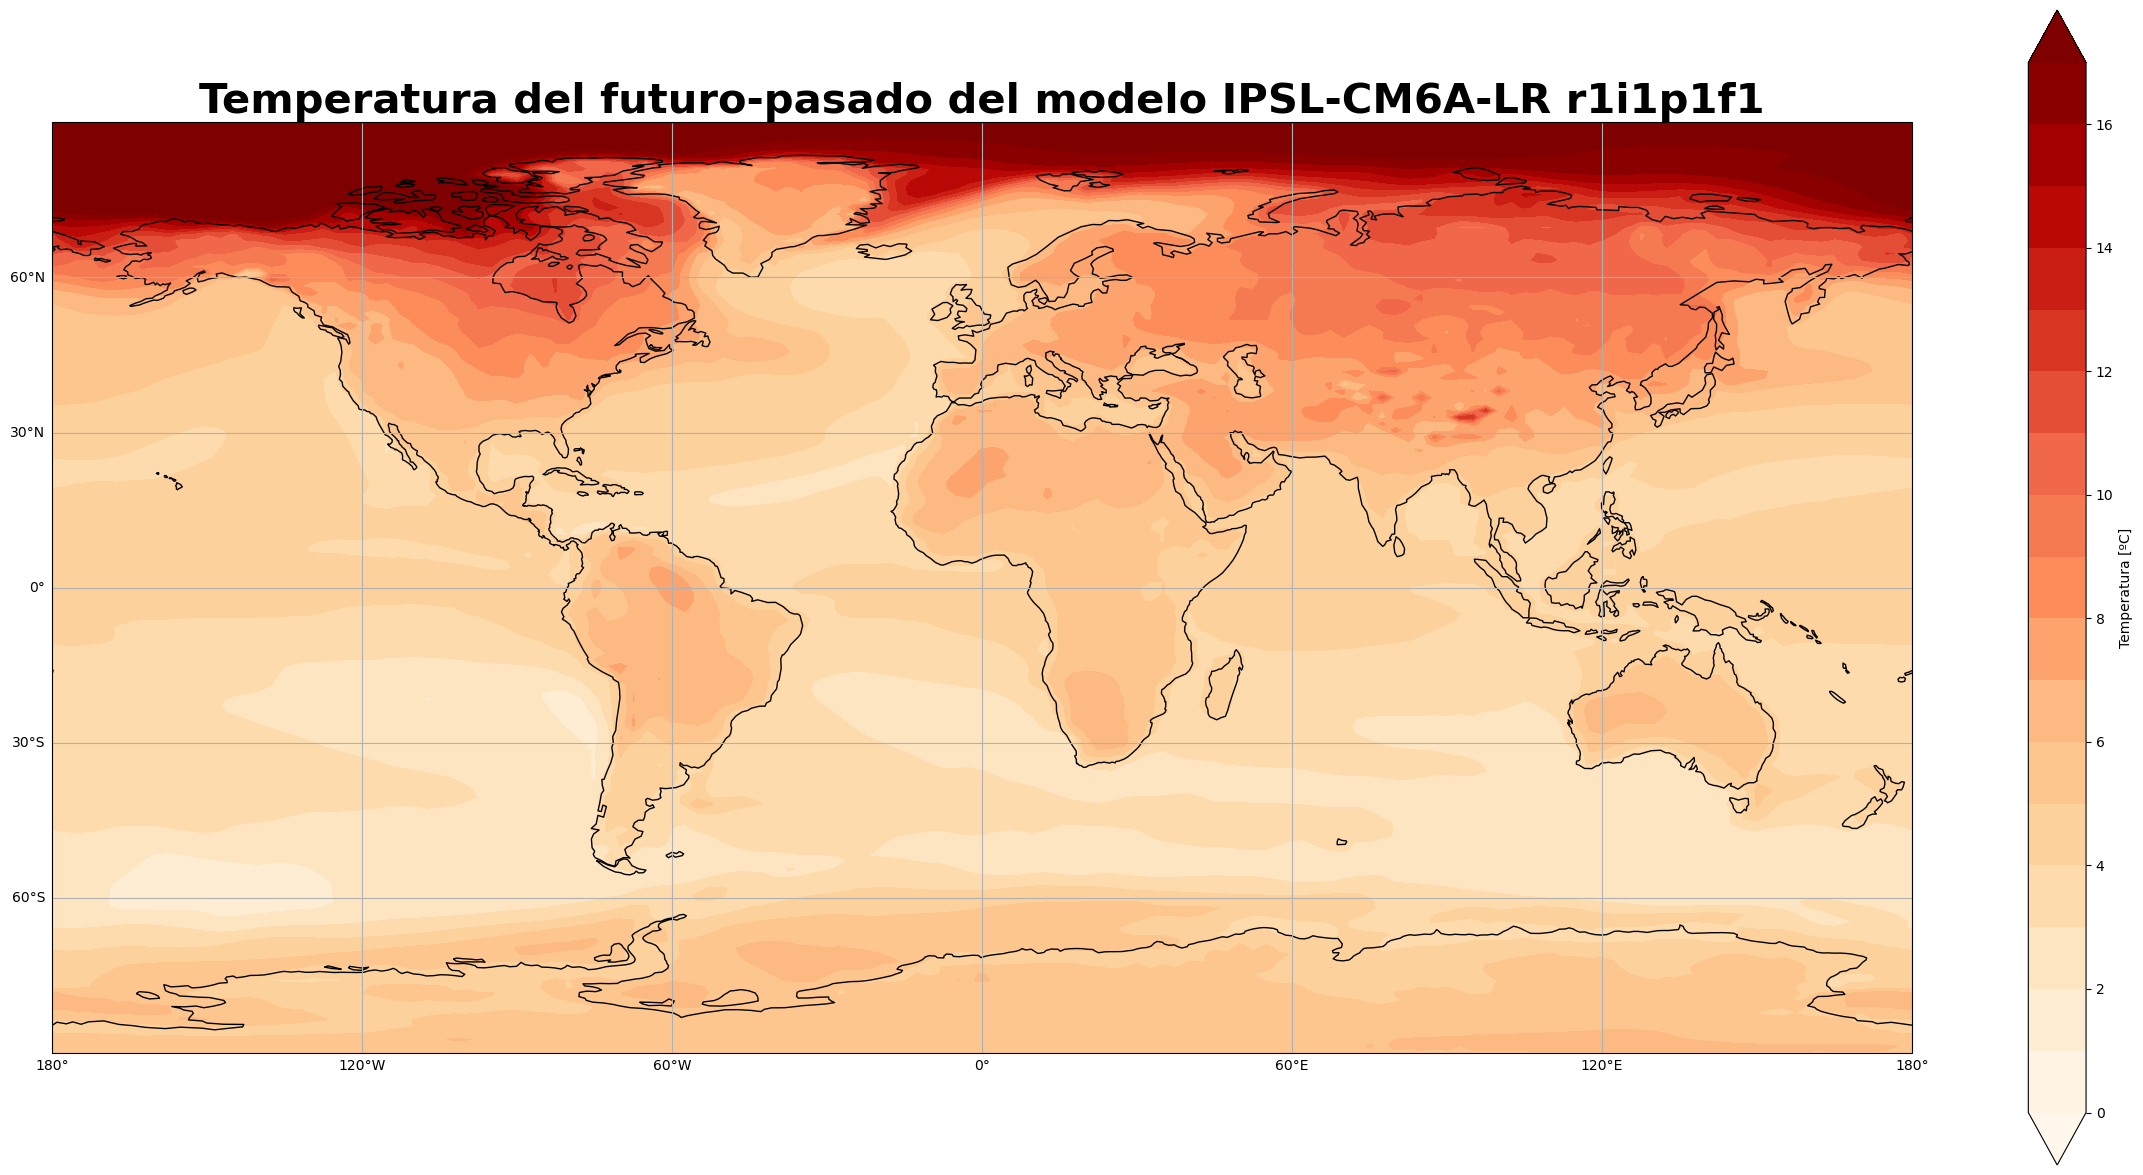

In [5]:
fig= plt.figure(figsize=(30,15))
ax= fig.add_subplot(1,1,1, projection= ccrs.PlateCarree(0))
levels= np.arange(0,18,1) #para el colorbar
ml1= ann_TAS_mean_fut-ann_TAS_mean_past
cml, clon= add_cyclic_point(ml1, coord=lon) #porque si no se crea una banda en blanco
im= ax.contourf(clon,lat,cml,levels,cmap='OrRd', extend='both')
ax.coastlines()
fig.colorbar(im,ax=ax, label='Temperatura [ºC]')
gl=ax.gridlines(draw_labels = True)
gl.ylabels_right = False
gl.xlabels_top = False
ax.set_title('Temperatura del futuro-pasado del modelo IPSL-CM6A-LR r1i1p1f1', fontsize=30, weight='bold')
fig.savefig('Temperatura del futuro-pasado del modelo IPSL-CM6A-LR r1i1p1f1.png')

### 1.2.	Discrepancias entre modelos.

Repite la misma figura que en el apartado anterior, pero para el modelo CESM2-WACCM y compara los resultados con lo obtenido para el modelo IPSL-CM6A-LR. Ayuda: Para poder comparar los resultados los gráficos deben tener la misma barra de colores. Seguimos por tanto los mismos pasos que en el apartado anterior.

Leemos los archivos con la temperatura en las simulaciones histórica y ssp5-8.5

In [6]:
var11= r'CESM2-WACCM/tas_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
var22= r'CESM2-WACCM/tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc'

varii= nc.Dataset(path+var11)
varii2= nc.Dataset(path+var22)

Hacemos los cálculos de las medias de la variable en los periodos de estudio. 

In [7]:
lon2= varii.variables['lon'][:]
lat2= varii.variables['lat'][:]
TAS2= varii.variables['tas'][:]

nt2,nlat2,nlon2= TAS2.shape
nm=12 #numero de meses
nyears2= int(nt2/nm)
TAS2= np.reshape(TAS2, (int(nyears2),nm,nlat2,nlon2))
ann_TAS2= np.mean(TAS2,axis=1)
ann_TAS_past2= ann_TAS2[121:151,:,:]
ann_TAS_mean_past2= np.mean(ann_TAS_past2, axis=0) #promedio tas en el periodo presente
print(ann_TAS_mean_past2.shape)

TAS_fut2= varii2.variables['tas'][:]
nt_fut2,nlat_fut2,nlon_fut2= TAS_fut2.shape
nyears_fut2= int(nt_fut2/nm)
TAS_fut2= np.reshape(TAS_fut2, (int(nyears_fut2),nm,nlat_fut2,nlon_fut2))
print(TAS_fut2.shape)
ann_TAS_fut2= np.mean(TAS_fut2,axis=1)
ann_TAS_fut2= ann_TAS_fut2[-30:,:,:]
ann_TAS_mean_fut2= np.mean(ann_TAS_fut2,axis=0) #promedio tas en el periodo futuro (ultimos treinta años9)
#ann_TAS_mean_fut= np.reshape(ann_TAS_mean_fut, (nlat_fut,nlon_fut))
print(ann_TAS_mean_fut2.shape)

C:\Users\ideapad 5 15ITL05\AppData\Local\Temp\ipykernel_68784\2688682642.py:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  TAS2= varii.variables['tas'][:]


(192, 288)
(86, 12, 192, 288)
(192, 288)


C:\Users\ideapad 5 15ITL05\AppData\Local\Temp\ipykernel_68784\2688682642.py:14: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  TAS_fut2= varii2.variables['tas'][:]


Realizamos la representación gráfica de la diferencia futuro - periodo de referencia

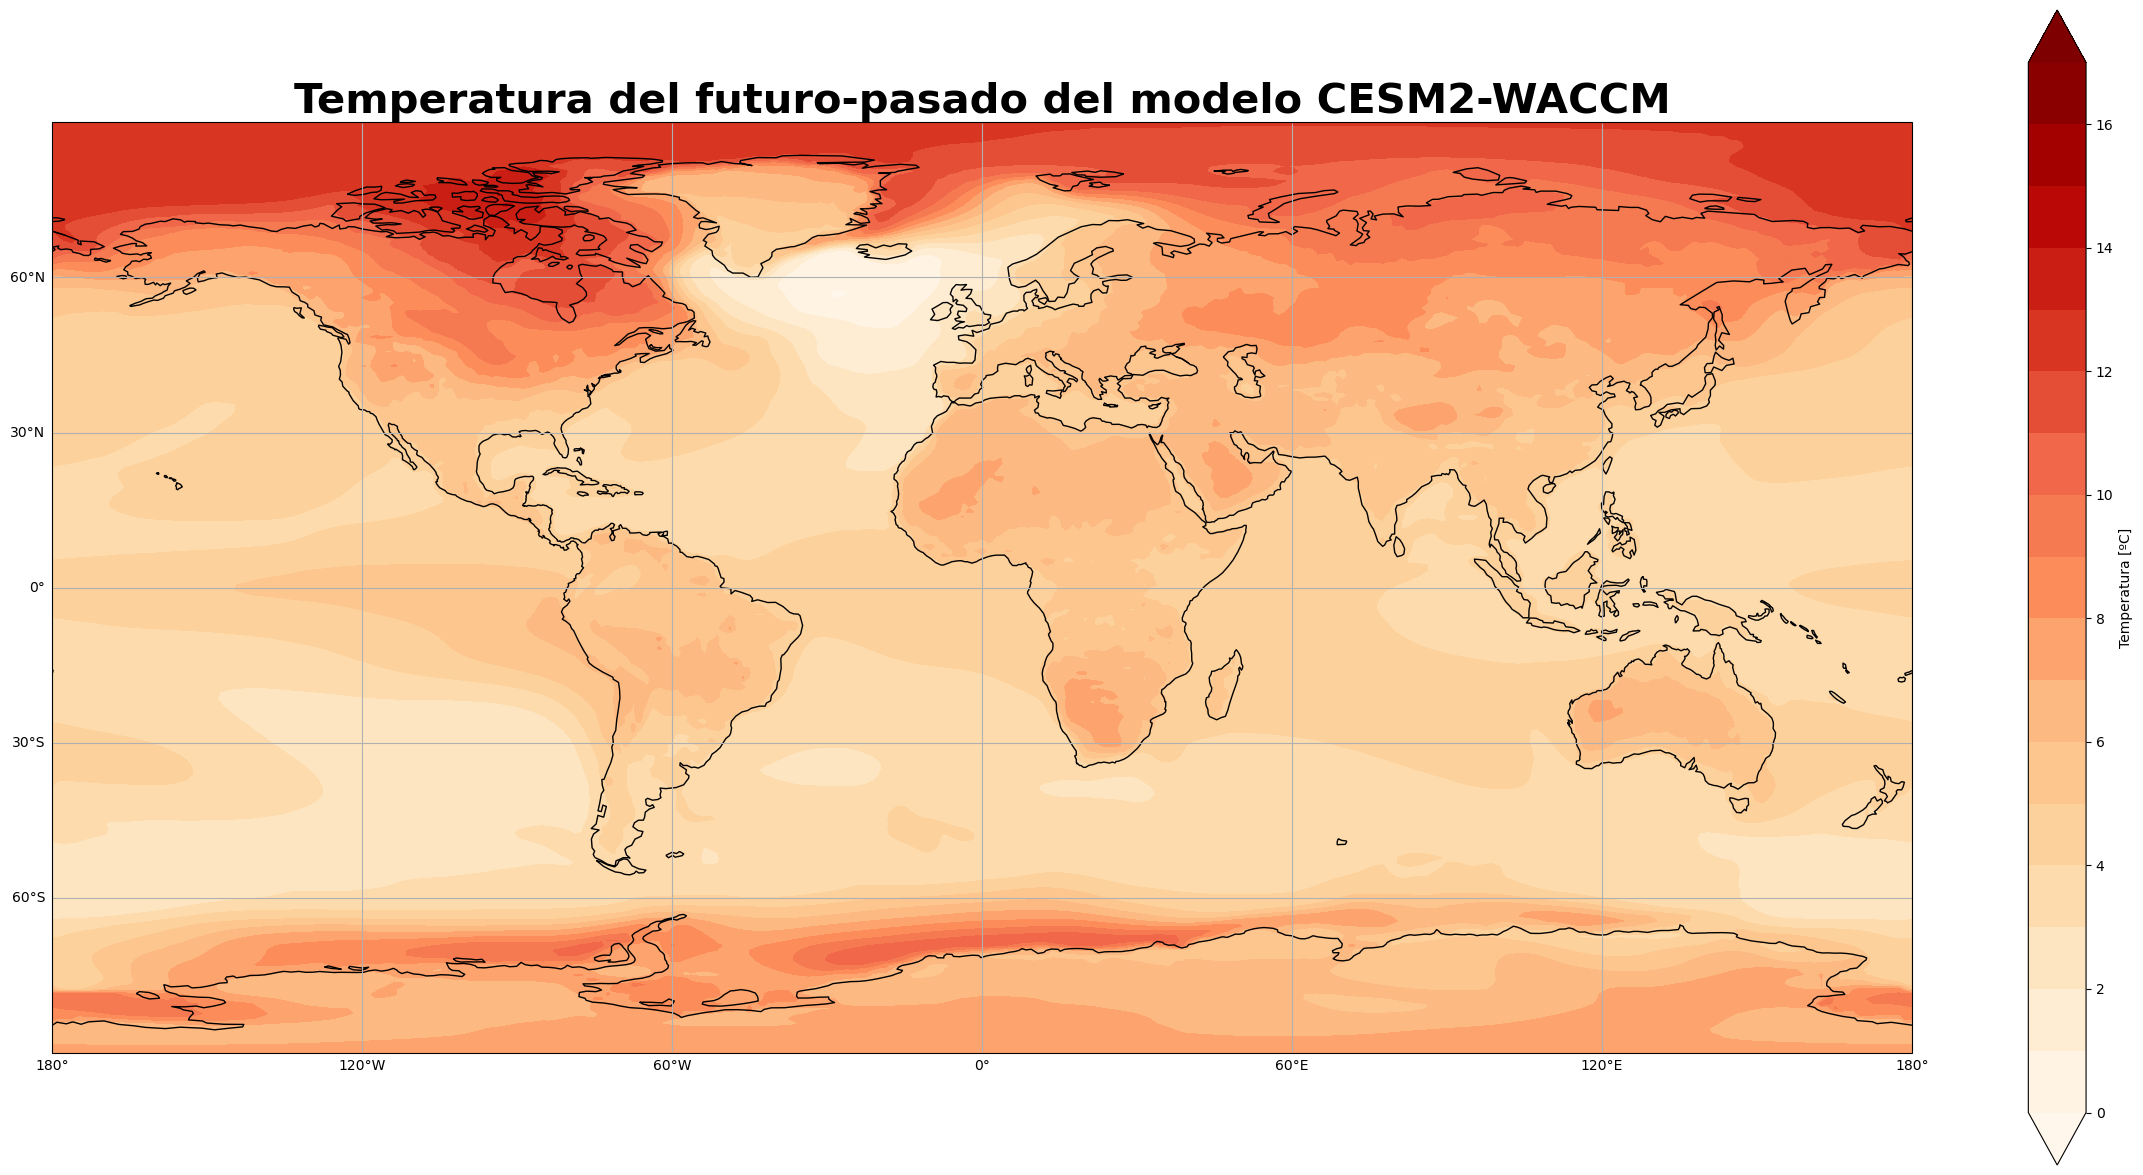

In [8]:
fig2= plt.figure(figsize=(30,15))
ax= fig2.add_subplot(1,1,1, projection= ccrs.PlateCarree(0))
levels= np.arange(0,18,1) #para el colorbar
ml2= ann_TAS_mean_fut2-ann_TAS_mean_past2
cml2, clon2= add_cyclic_point(ml2, coord=lon2) #porque si no se crea una banda en blanco
im2= ax.contourf(clon2,lat2,cml2,levels,cmap='OrRd', extend='both')
ax.coastlines()
fig2.colorbar(im2,ax=ax, label='Temperatura [ºC]')
gl=ax.gridlines(draw_labels = True)
gl.ylabels_right = False
gl.xlabels_top = False
ax.set_title('Temperatura del futuro-pasado del modelo CESM2-WACCM', fontsize=30, weight='bold')
fig2.savefig('Temperatura del futuro-pasado del modelo CESM2-WACCM.png')

### 1.3.	Efectos de la variabilidad interna.

Repite de nuevo el cálculo del punto 1.1, pero para cada uno de los otros dos miembros del ensemble de las simulaciones (r2i1p1f1 y r3i1p1f1) del modelo IPSL-CM6A-LR. Finalmente, calcula el promedio de los 3 miembros del ensemble.

#### Cálculos para el miembro r2i1p1f1 

Lectura de ficheros

In [9]:
Var1= r'IPSL-CM6A-LR/tas_Amon_IPSL-CM6A-LR_historical_r2i1p1f1_gr_185001-201412.nc'
Var2= r"IPSL-CM6A-LR/tas_Amon_IPSL-CM6A-LR_ssp585_r2i1p1f1_gr_201501-210012.nc"
Vari= nc.Dataset(path+Var1)
Vari2= nc.Dataset(path+Var2)

Selección de periodos de estudio y cálculos de medias

In [10]:
lon= Vari.variables['lon'][:]
lat= Vari.variables['lat'][:]
TAS= Vari.variables['tas'][:]

nt,nlat,nlon= TAS.shape
nm=12 #numero de meses
nyears= int(nt/nm)
TAS= np.reshape(TAS, (int(nyears),nm,nlat,nlon))
ann_TAS= np.mean(TAS,axis=1)
ann_TAS_past= ann_TAS[121:151,:,:]
ann_TAS_mean_past= np.mean(ann_TAS_past, axis=0) #promedio tas en el periodo presente

TAS_fut= Vari2.variables['tas'][:]
nt_fut,nlat_fut,nlon_fut= TAS_fut.shape
nyears_fut= int(nt_fut/nm)
TAS_fut= np.reshape(TAS_fut, (int(nyears_fut),nm,nlat_fut,nlon_fut))
print(TAS_fut.shape)
ann_TAS_fut= np.mean(TAS_fut,axis=1)
ann_TAS_fut= ann_TAS_fut[-30:,:,:]
ann_TAS_mean_fut= np.mean(ann_TAS_fut,axis=0)

(86, 12, 143, 144)


Hacemos la representación de la diferencia futuro menos periodo de referencia

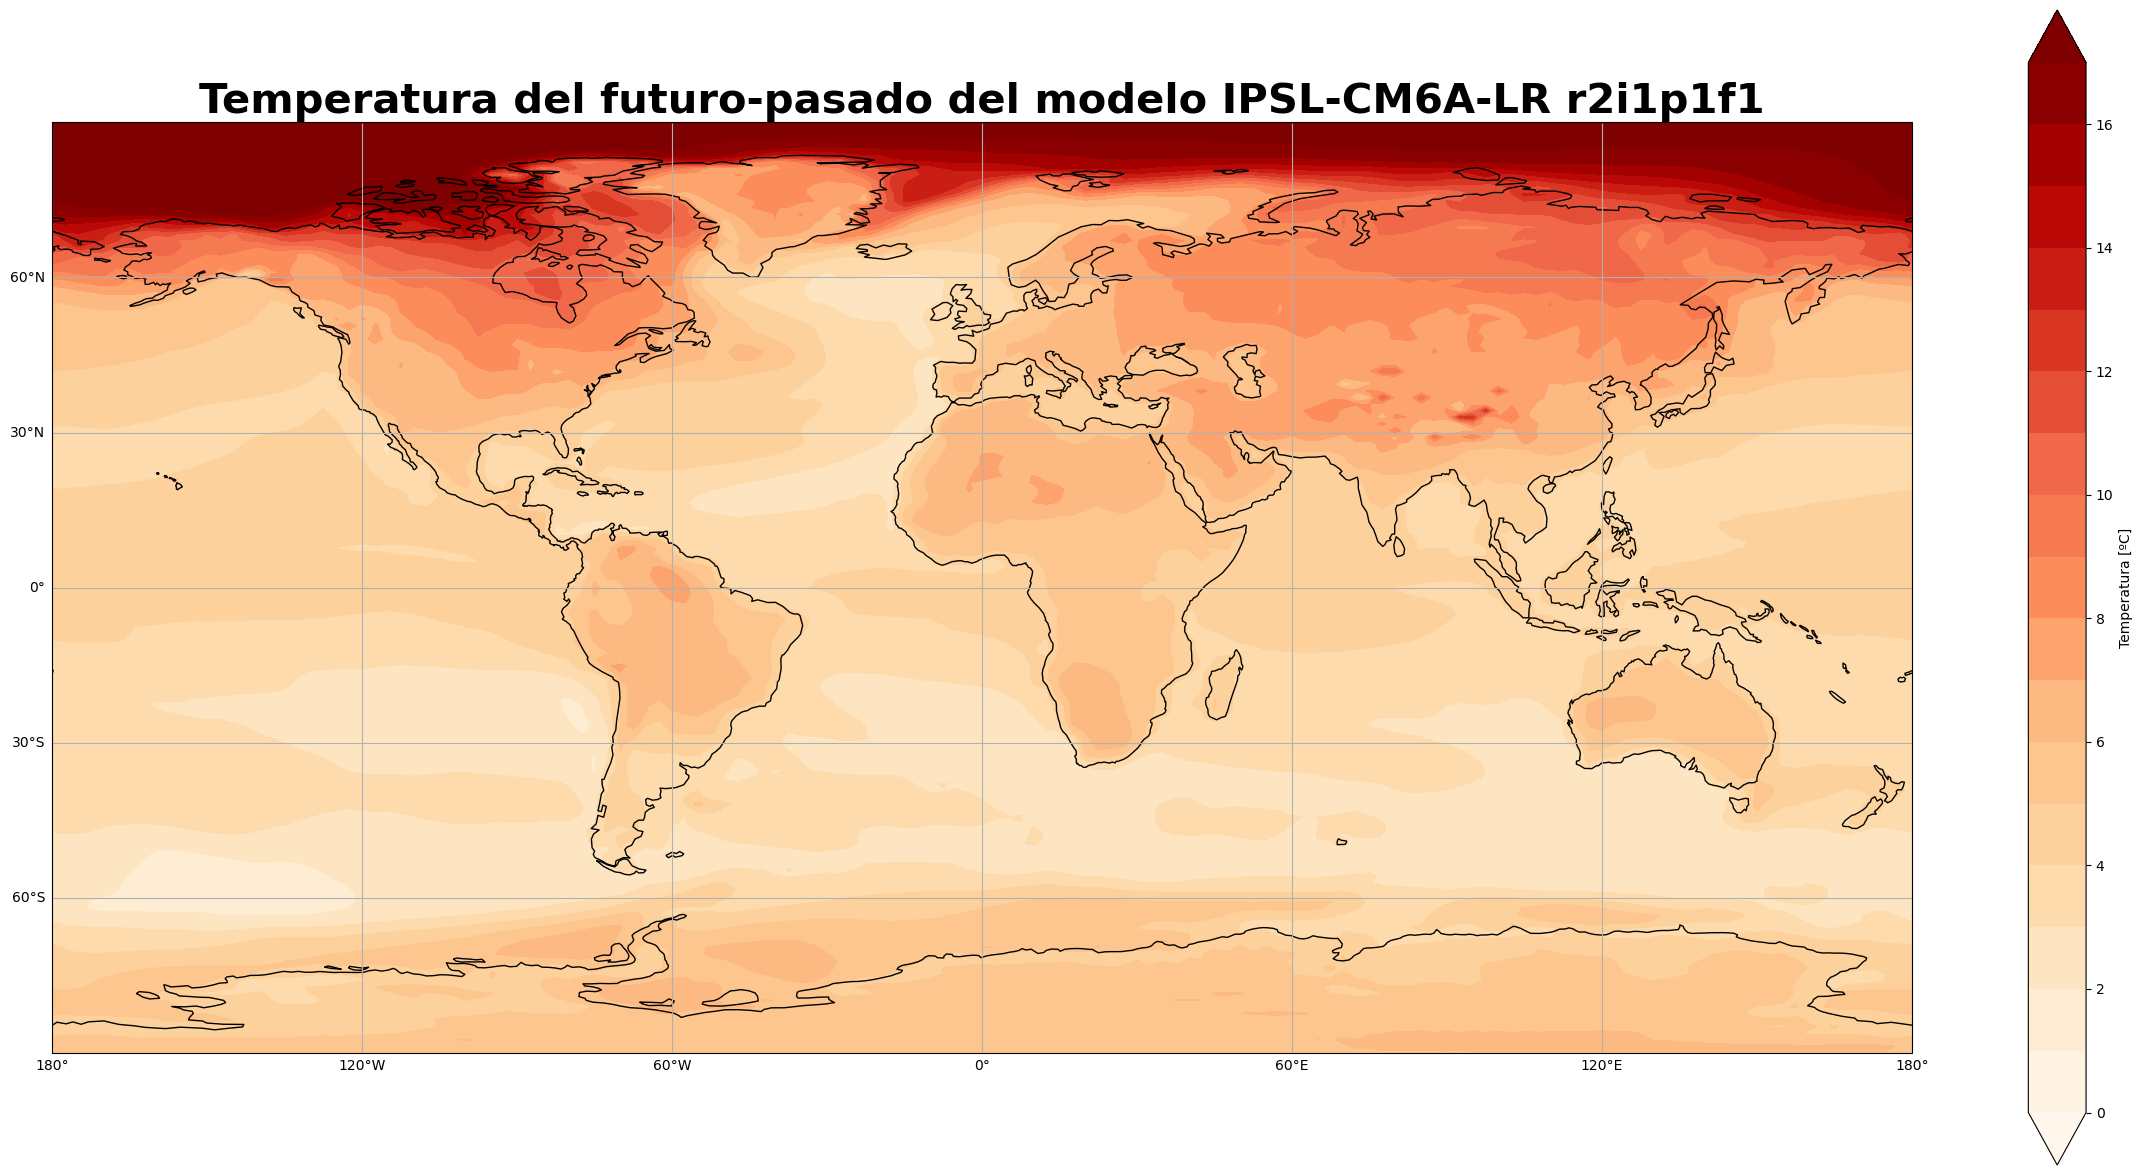

In [11]:
fig= plt.figure(figsize=(30,15))
ax= fig.add_subplot(1,1,1, projection= ccrs.PlateCarree(0))
levels= np.arange(0,18,1) #para el colorbar
ml2= ann_TAS_mean_fut-ann_TAS_mean_past
cml, clon= add_cyclic_point(ml2, coord=lon) #porque si no se crea una banda en blanco
im= ax.contourf(clon,lat,cml,levels,cmap='OrRd', extend='both')
ax.coastlines()
fig.colorbar(im,ax=ax, label='Temperatura [ºC]')
gl=ax.gridlines(draw_labels = True)
gl.ylabels_right = False
gl.xlabels_top = False
ax.set_title('Temperatura del futuro-pasado del modelo IPSL-CM6A-LR r2i1p1f1', fontsize=30, weight='bold')
fig.savefig('Temperatura del futuro-pasado del modelo IPSL-CM6A-LR r2i1p1f1.png')

#### Cálculos para el miembro r3i1p1f1 

Lectura de ficheros

In [12]:
VAr1= r'IPSL-CM6A-LR/tas_Amon_IPSL-CM6A-LR_historical_r3i1p1f1_gr_185001-201412.nc'
VAr2= r"IPSL-CM6A-LR/tas_Amon_IPSL-CM6A-LR_ssp585_r3i1p1f1_gr_201501-210012.nc"
VAri= nc.Dataset(path+Var1)
VAri2= nc.Dataset(path+Var2)

Selección de periodos de estudio y cálculo de medias

In [13]:
lon= VAri.variables['lon'][:]
lat= VAri.variables['lat'][:]
TAS= VAri.variables['tas'][:]

nt,nlat,nlon= TAS.shape
nm=12 #numero de meses
nyears= int(nt/nm)
TAS= np.reshape(TAS, (int(nyears),nm,nlat,nlon))
ann_TAS= np.mean(TAS,axis=1)
ann_TAS_past= ann_TAS[121:151,:,:]
ann_TAS_mean_past= np.mean(ann_TAS_past, axis=0) #promedio tas en el periodo presente

TAS_fut= VAri2.variables['tas'][:]
nt_fut,nlat_fut,nlon_fut= TAS_fut.shape
nyears_fut= int(nt_fut/nm)
TAS_fut= np.reshape(TAS_fut, (int(nyears_fut),nm,nlat_fut,nlon_fut))
print(TAS_fut.shape)
ann_TAS_fut= np.mean(TAS_fut,axis=1)
ann_TAS_fut= ann_TAS_fut[-30:,:,:]
ann_TAS_mean_fut= np.mean(ann_TAS_fut,axis=0)

(86, 12, 143, 144)


Hacemos la representación de la diferencia futuro menos periodo de referencia

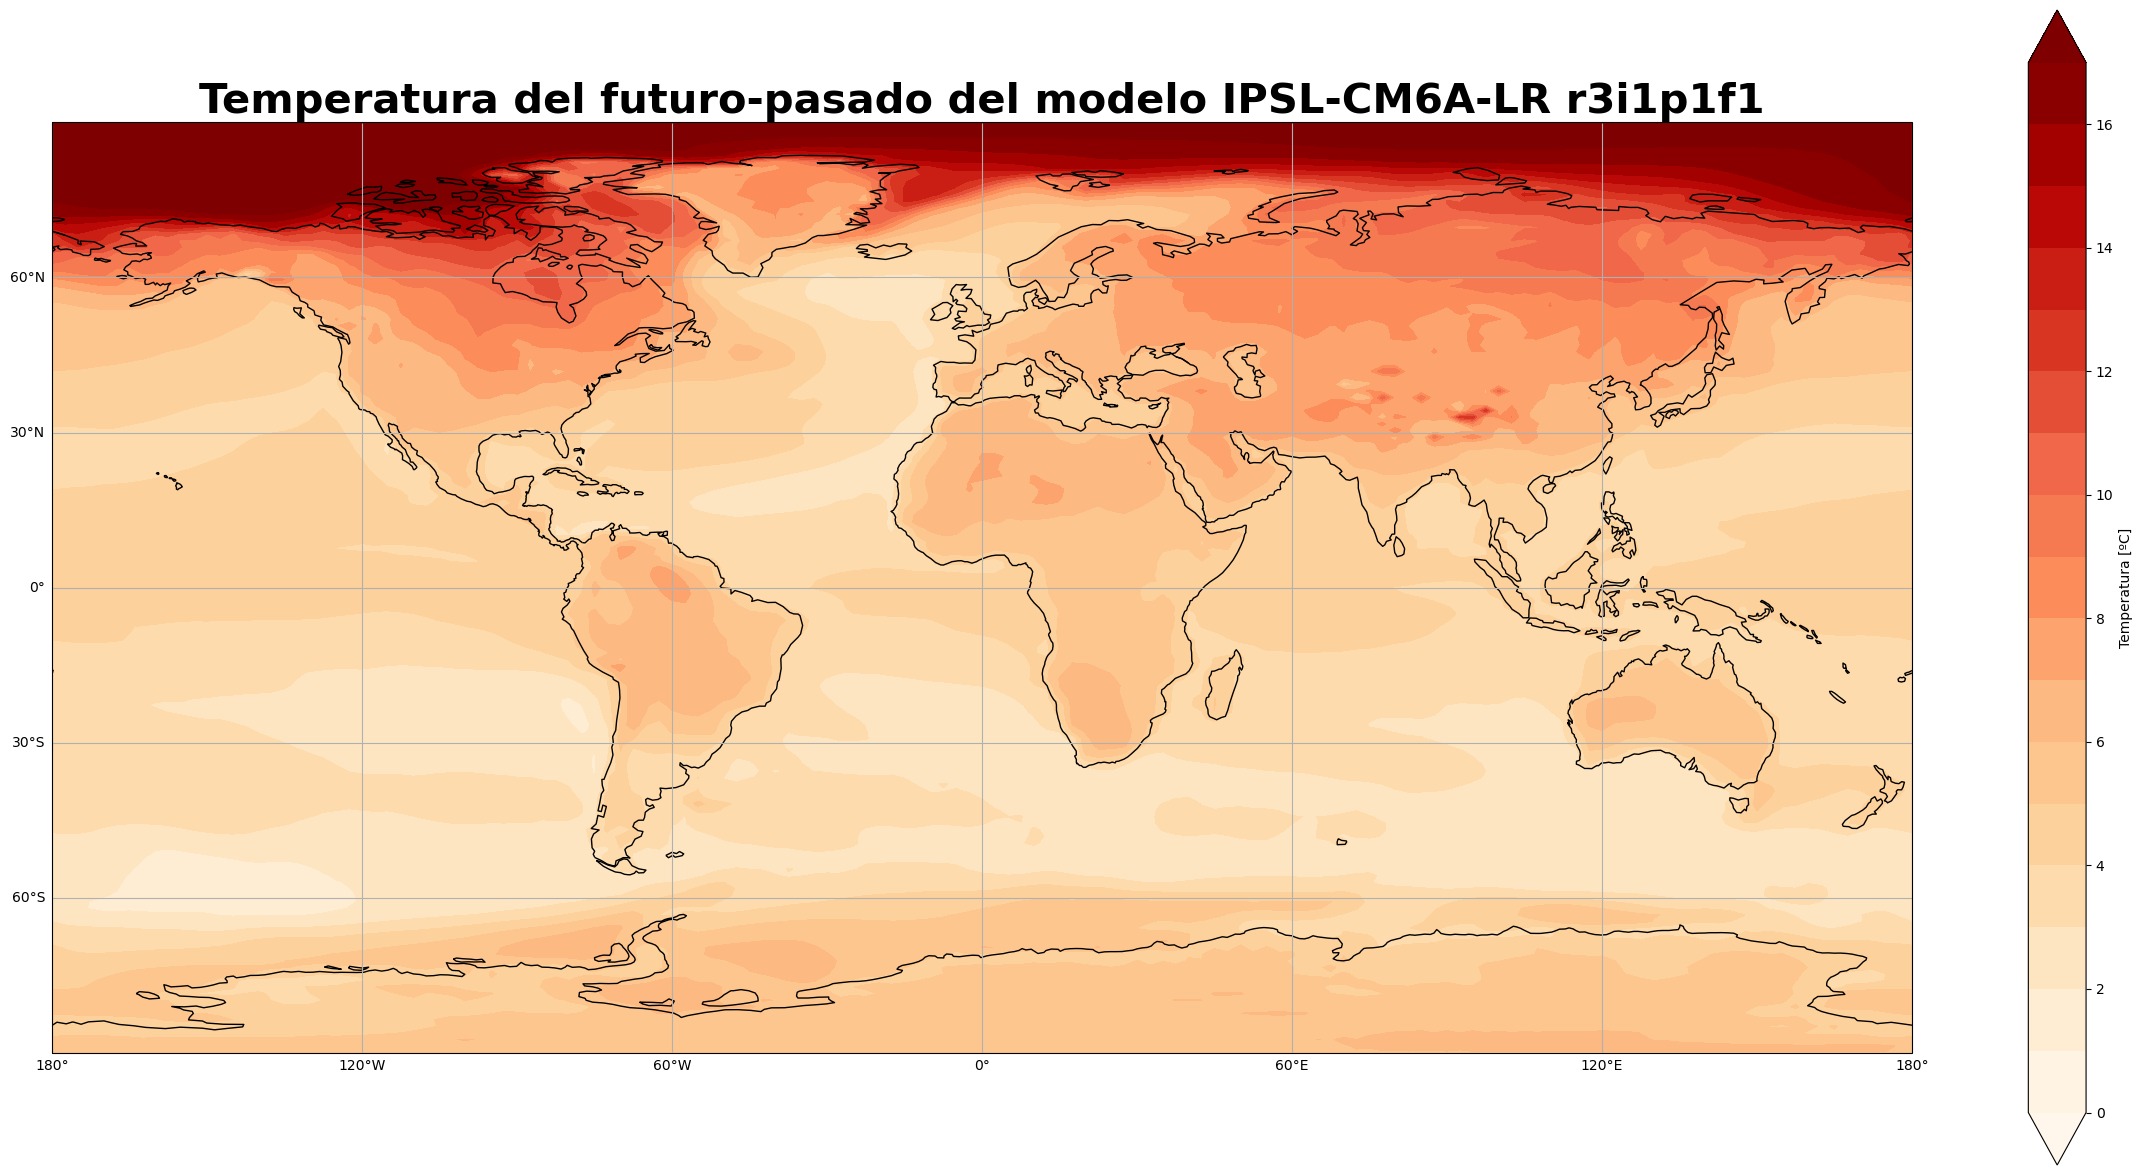

In [14]:
fig= plt.figure(figsize=(30,15))
ax= fig.add_subplot(1,1,1, projection= ccrs.PlateCarree(0))
levels= np.arange(0,18,1) #para el colorbar
ml3= ann_TAS_mean_fut-ann_TAS_mean_past
cml, clon= add_cyclic_point(ml3, coord=lon) #porque si no se crea una banda en blanco
im= ax.contourf(clon,lat,cml,levels,cmap='OrRd', extend='both')
ax.coastlines()
fig.colorbar(im,ax=ax, label='Temperatura [ºC]')
gl=ax.gridlines(draw_labels = True)
gl.ylabels_right = False
gl.xlabels_top = False
ax.set_title('Temperatura del futuro-pasado del modelo IPSL-CM6A-LR r3i1p1f1', fontsize=30, weight='bold')
fig.savefig('Temperatura del futuro-pasado del modelo IPSL-CM6A-LR r3i1p1f1.png')

#### Cálculos y representación para la media de los tres miembros del ensemble de condiciones iniciales

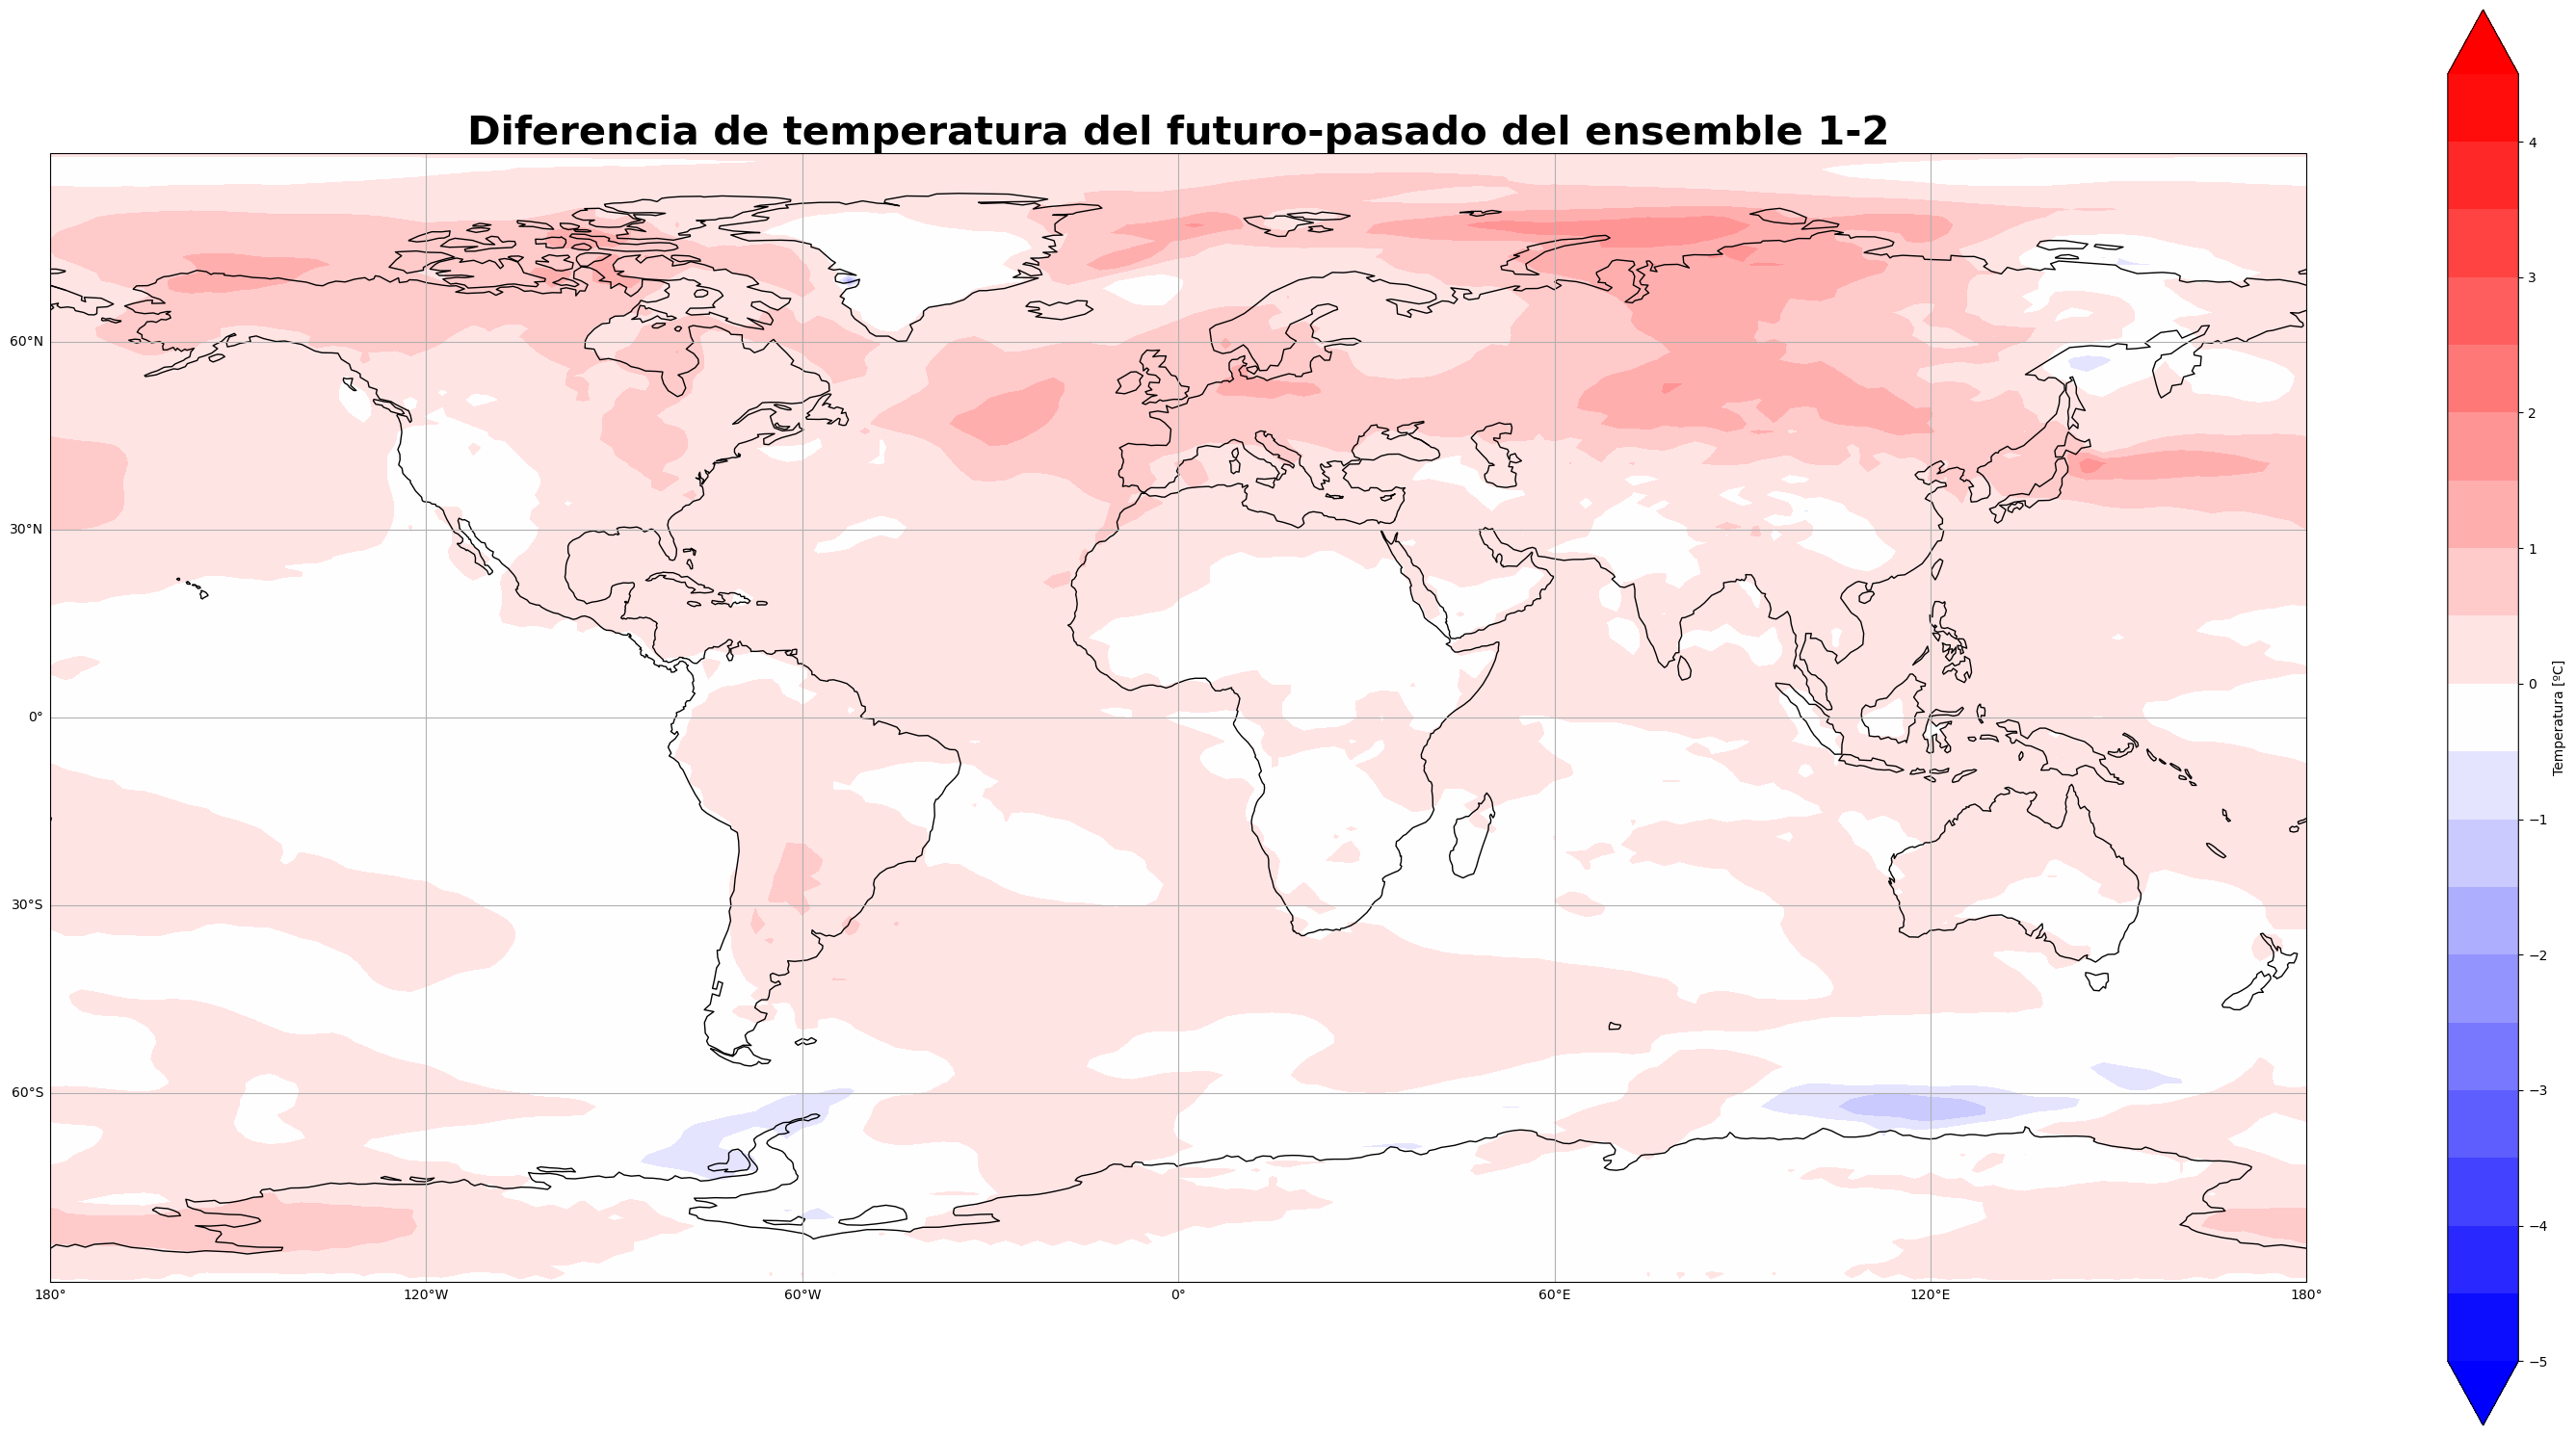

In [15]:
ML= (ml1-ml2)
fig= plt.figure(figsize=(30,15))
ax= fig.add_subplot(1,1,1, projection= ccrs.PlateCarree(0))
levels= np.arange(-5,5,0.5) #para el colorbar
cml, clon= add_cyclic_point(ML, coord=lon) #porque si no se crea una banda en blanco
im= ax.contourf(clon,lat,cml,levels,cmap='bwr', extend='both')
ax.coastlines()
fig.colorbar(im,ax=ax, label='Temperatura [ºC]')
gl=ax.gridlines(draw_labels = True)
gl.ylabels_right = False
gl.xlabels_top = False
ax.set_title('Diferencia de temperatura del futuro-pasado del ensemble 1-2', fontsize=30, weight='bold')
plt.tight_layout()
fig.savefig('Diferencia de Temperatura del futuro-pasado del ensemble 1-2 modelo IPSL-CM6A-LR.png')

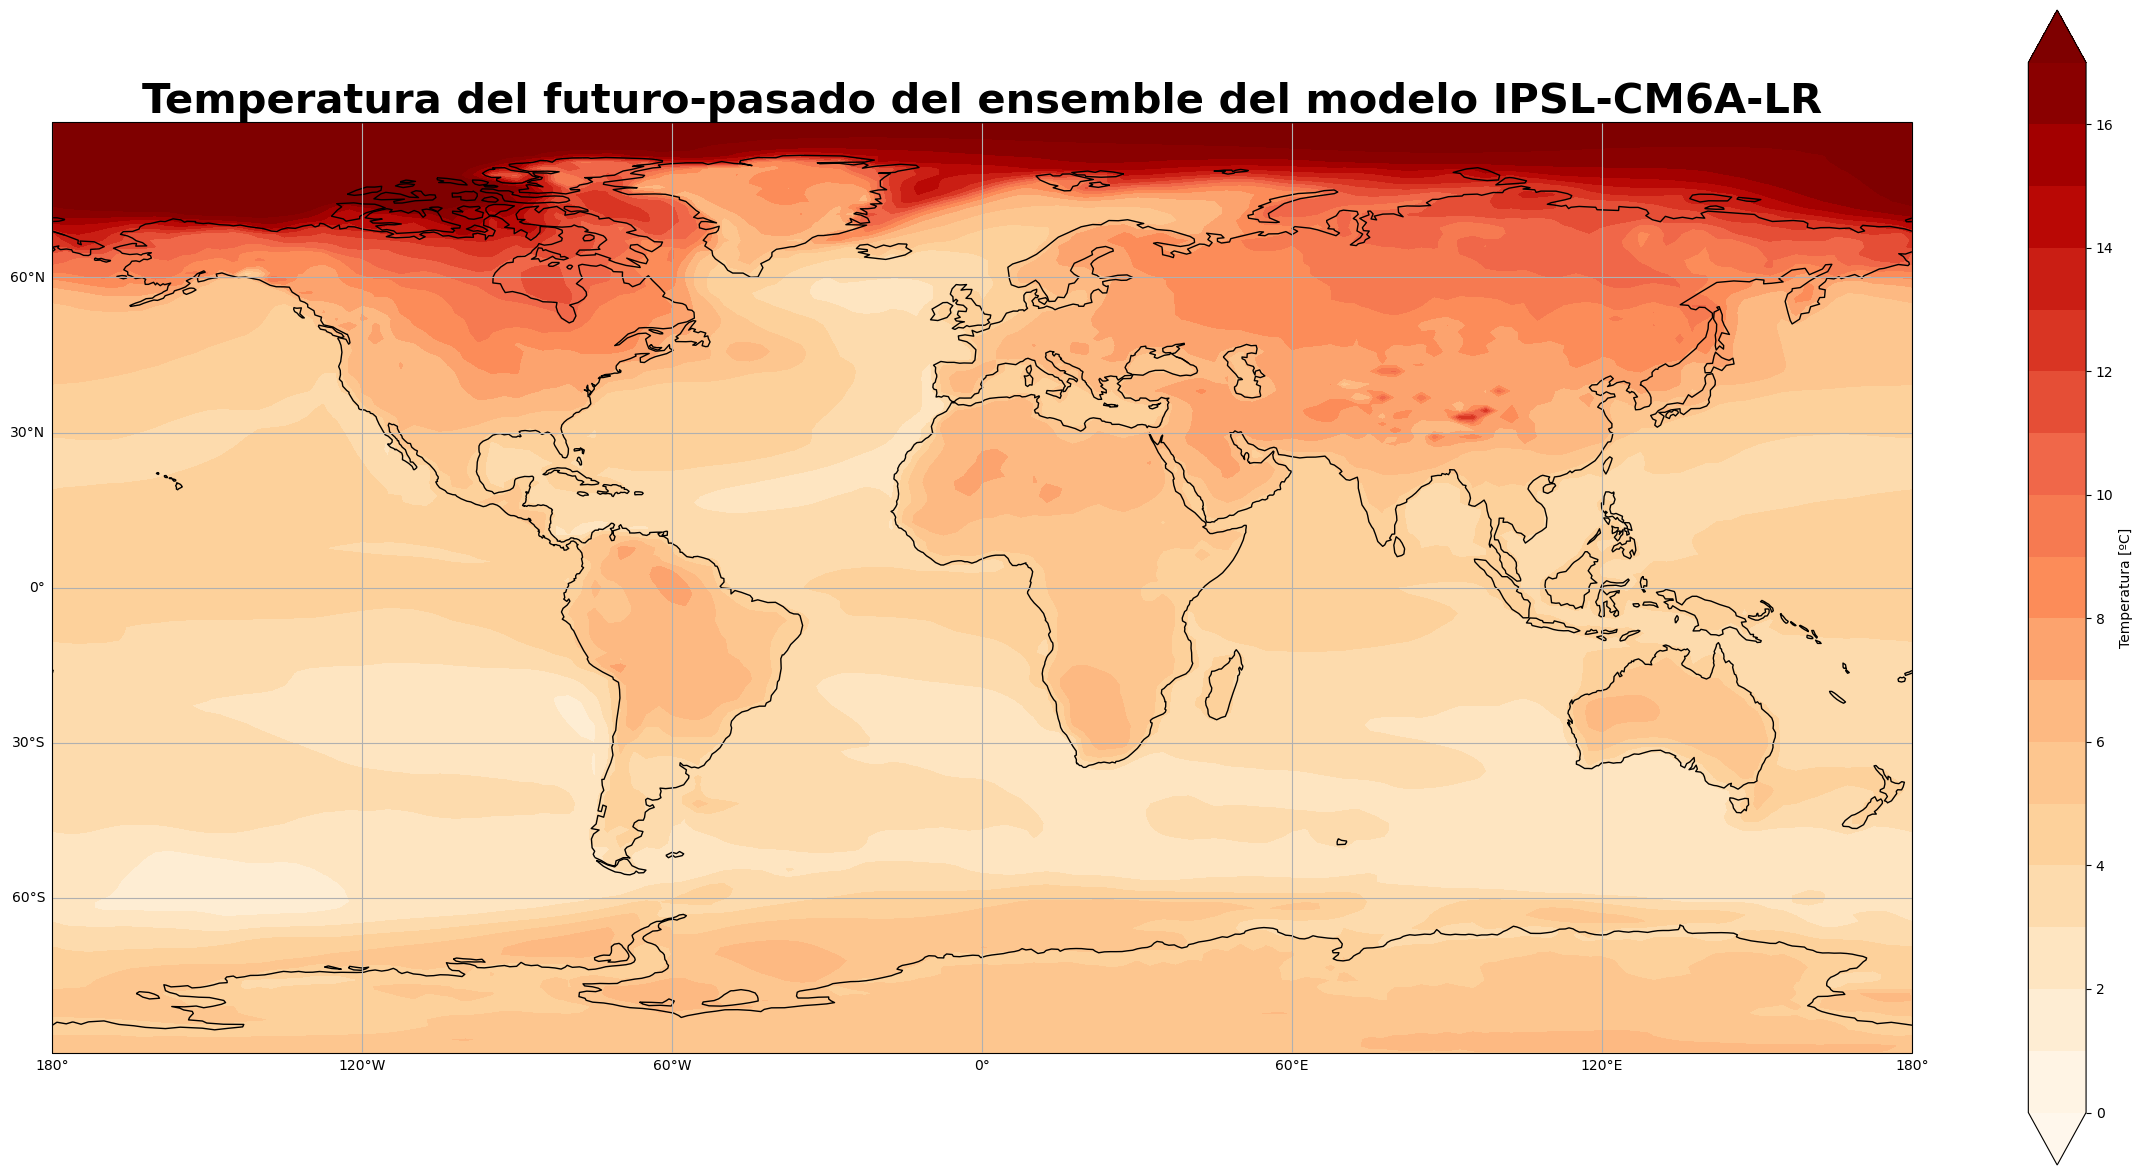

In [16]:
ML= (ml1+ml2+ml3)/3
fig= plt.figure(figsize=(30,15))
ax= fig.add_subplot(1,1,1, projection= ccrs.PlateCarree(0))
levels= np.arange(0,18,1) #para el colorbar
cml, clon= add_cyclic_point(ML, coord=lon) #porque si no se crea una banda en blanco
im= ax.contourf(clon,lat,cml,levels,cmap='OrRd', extend='both')
ax.coastlines()
fig.colorbar(im,ax=ax, label='Temperatura [ºC]')
gl=ax.gridlines(draw_labels = True)
gl.ylabels_right = False
gl.xlabels_top = False
ax.set_title('Temperatura del futuro-pasado del ensemble del modelo IPSL-CM6A-LR', fontsize=30, weight='bold')
fig.savefig('Temperatura del futuro-pasado del promedio ensemble modelo IPSL-CM6A-LR.png')

# Ejercicio 2: Cambios en el estado medio de la troposfera y estratosfera

En este ejercicio analizaremos los cambios en la temperatura y en la circulación media en la troposfera y estratosfera. Para ello usaremos un solo miembro del ensemble de cada simulación. Ayuda: Para poder ver correctamente tanto troposfera y estratosfera tenéis que representar el eje y en escala logarítmica. 

### 2.1. Cambios en la temperatura en troposfera y estratosfera

Analiza los cambios en la climatología anual de la media zonal de la temperatura en la troposfera y estratosfera entre el periodo de referencia y el “futuro” en los modelos IPSL-CM6A-LR y CESM2-WACCM. 

#### Comenzamos con los pasos para el modelo IPSL-CM6A-LR
Lectura de los ficheros

In [17]:
var1= r'IPSL-CM6A-LR/ta_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412_zm3.nc'
var2= r'IPSL-CM6A-LR/ta_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_201501-210012_zm3.nc'
fil = nc.Dataset(path+ var1)
fil2 = nc.Dataset(path + var2)
lev = fil.variables['plev'][:]
latT = fil.variables['lat'][:]
TA = fil.variables['ta'][:]
TA_fut = fil2.variables['ta'][:]

Cálculo de medias para los periodos de referencia y futuro. 

In [18]:
nt, nlev, ny, nx = TA.shape
nm = 12
nyr = int(nt/nm)
TA = np.reshape(TA,[nyr,nm,nlev,ny])
TAm = np.mean(TA,axis = 1)
TAmpast = TAm[121:151,:,:]
mediaTpast = np.mean(TAmpast,axis =0)
mediaTpast = np.reshape(mediaTpast,(nlev,ny))

###futuro
ntf, nlev, ny, nx = TA_fut.shape
nm = 12
nyrf = int(ntf/nm)
TA_fut = np.reshape(TA_fut,[nyrf,nm,nlev,ny])
TAm_fut = np.mean(TA_fut,axis = 1)
TAmfut = TAm_fut[-30:,:,:]
mediaTfut = np.mean(TAmfut,axis =0)
print(mediaTfut.shape)
dif_T = mediaTfut-mediaTpast

(18, 131)


Representación de las diferencias entre ambos periodos

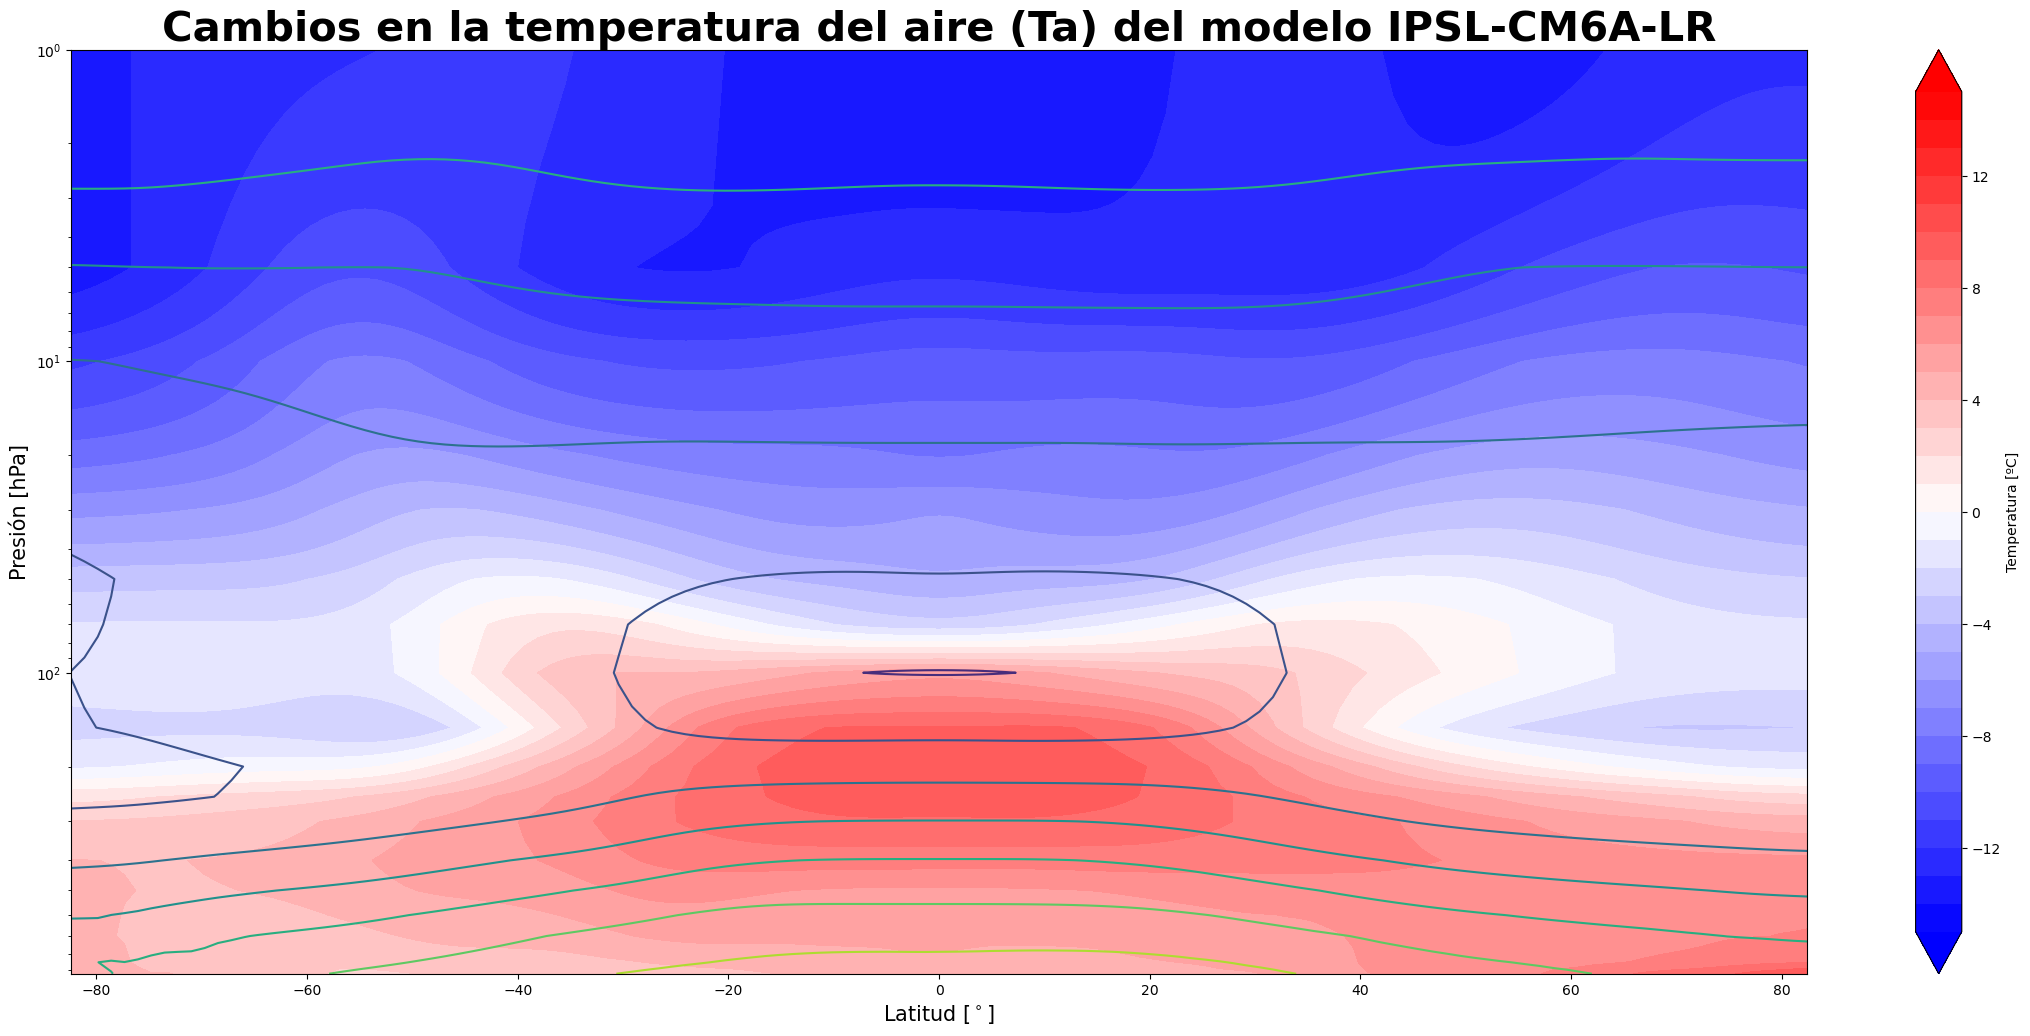

In [19]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1)
levels = np.arange(-15,16,1)
im = ax.contourf(latT,lev/100,dif_T,levels,cmap='bwr',extend='both')
ax.set_yscale('log')
ax.invert_yaxis()
fig.colorbar(im,ax=ax, label='Temperatura [ºC]') #Para la barra de colores
ii = ax.contour(latT,lev/100,mediaTpast)
ax.set_xlabel('Latitud [$^\circ$]',fontsize=15)
ax.set_ylabel('Presión [hPa]',fontsize=15)
ax.set_title('Cambios en la temperatura del aire (Ta) del modelo IPSL-CM6A-LR',fontsize=30,weight='bold')
fig.savefig('Cambios en la temperatura del aire (Ta) del modelo IPSL-CM6A-LR.png')

#### Repetimos los pasos para el modelo CESM2-WACCM

In [20]:
var1= r'CESM2-WACCM/ta_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412_zm3.nc'
var2= r'CESM2-WACCM/ta_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012_zm3.nc'
fil = nc.Dataset(path+ var1)
fil2 = nc.Dataset(path + var2)
lev = fil.variables['plev'][:]
latT = fil.variables['lat'][:]
TA = fil.variables['ta'][:]
TA_fut = fil2.variables['ta'][:]

nt, nlev, ny, nx = TA.shape
nm = 12
nyr = int(nt/nm)
TA = np.reshape(TA,[nyr,nm,nlev,ny])
TAm = np.mean(TA,axis = 1)
TAmpast = TAm[121:151,:,:]
mediaTpast = np.mean(TAmpast,axis =0)
mediaTpast = np.reshape(mediaTpast,(nlev,ny))

###futuro
ntf, nlev, ny, nx = TA_fut.shape
nm = 12
nyrf = int(ntf/nm)
TA_fut = np.reshape(TA_fut,[nyrf,nm,nlev,ny])
TAm_fut = np.mean(TA_fut,axis = 1)
TAmfut = TAm_fut[-30:,:,:]
mediaTfut = np.mean(TAmfut,axis =0)
print(mediaTfut.shape)
dif_T = mediaTfut-mediaTpast

(18, 176)


Realizamos la representación para CESM2-WACCM

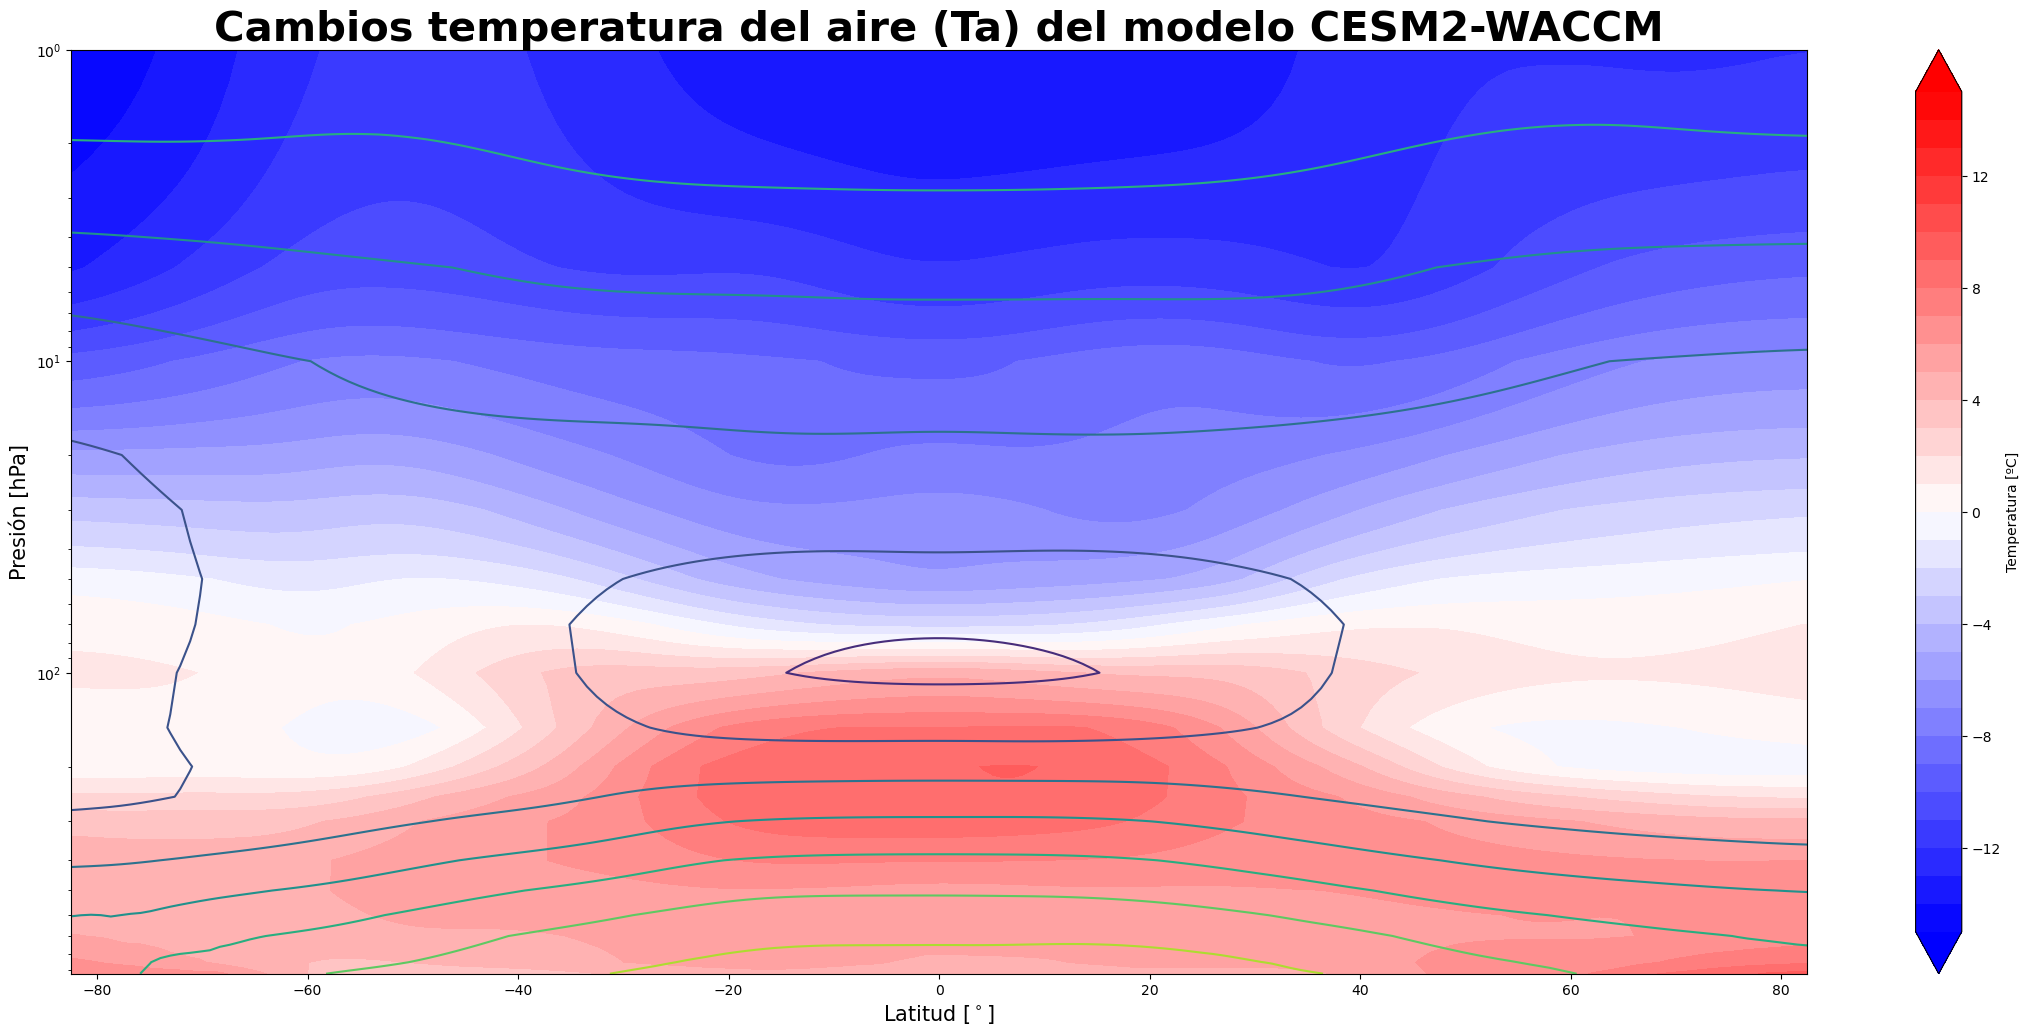

In [21]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1)
levels = np.arange(-15,16,1)
im = ax.contourf(latT,lev/100,dif_T,levels,cmap='bwr',extend='both')
ax.set_yscale('log')
ax.invert_yaxis()
fig.colorbar(im,ax=ax, label='Temperatura [ºC]') #Para la barra de colores
ii = ax.contour(latT,lev/100,mediaTpast)
ax.set_xlabel('Latitud [$^\circ$]',fontsize=15)
ax.set_ylabel('Presión [hPa]',fontsize=15)
ax.set_title('Cambios temperatura del aire (Ta) del modelo CESM2-WACCM',fontsize=30,weight='bold')
fig.savefig('Cambios temperatura del aire (Ta) del modelo CESM2-WACCM.png')

### 2.2. Cambios en la circulación en invierno.

Repetimos todos los pasos anteriores que en la sección anterior pero para el viento zonal. 

#### Comenzamos con los pasos para IPSL-CM6A-LR
Lectura de los ficheros

In [22]:
var1_u= r'IPSL-CM6A-LR/ua_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412_zm3.nc'
var2_u= r'IPSL-CM6A-LR/ua_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_201501-210012_zm3.nc'
file1= xr.open_dataset(path+var1_u)
file2= xr.open_dataset(path+var2_u)

Realizamos la selección de los meses invernales y luego calculamos los promedios de la variable para cada periodo de estudio

In [23]:
#seleccionamos los meses invernales ayudándonos de la función gropuby de xarray
file1_inv= file1.groupby('time.season')['DJF']
file2_inv= file2.groupby('time.season')['DJF']

In [24]:
lev = file1_inv.plev
latT = file1_inv.lat
ua = file1_inv.ua
ua_fut = file2_inv.ua

nt, nlev, ny, nx = ua.shape
nm = 3
nyr = int(nt/nm)
ua = np.reshape(ua,[nyr,nm,nlev,ny])
ua_mean = np.mean(ua,axis = 1)
ua_mean_past = ua_mean[121:151,:,:]
mean_u_past = np.mean(ua_mean_past,axis =0)
mean_u_past = np.reshape(mean_u_past,(nlev,ny))

###futuro
ntf, nlev, ny, nx = ua_fut.shape
nm = 3
nyrf = int(ntf/nm)
ua_fut = np.reshape(ua_fut,[nyrf,nm,nlev,ny])
ua_mean_fut = np.mean(ua_fut,axis = 1)
ua_mean_fut = ua_mean_fut[-30:,:,:]
mean_u_future = np.mean(ua_mean_fut,axis =0)
print(mean_u_future.shape)
dif_u = np.array(mean_u_future)-np.array(mean_u_past)

(18, 131)


Realizamos la representación

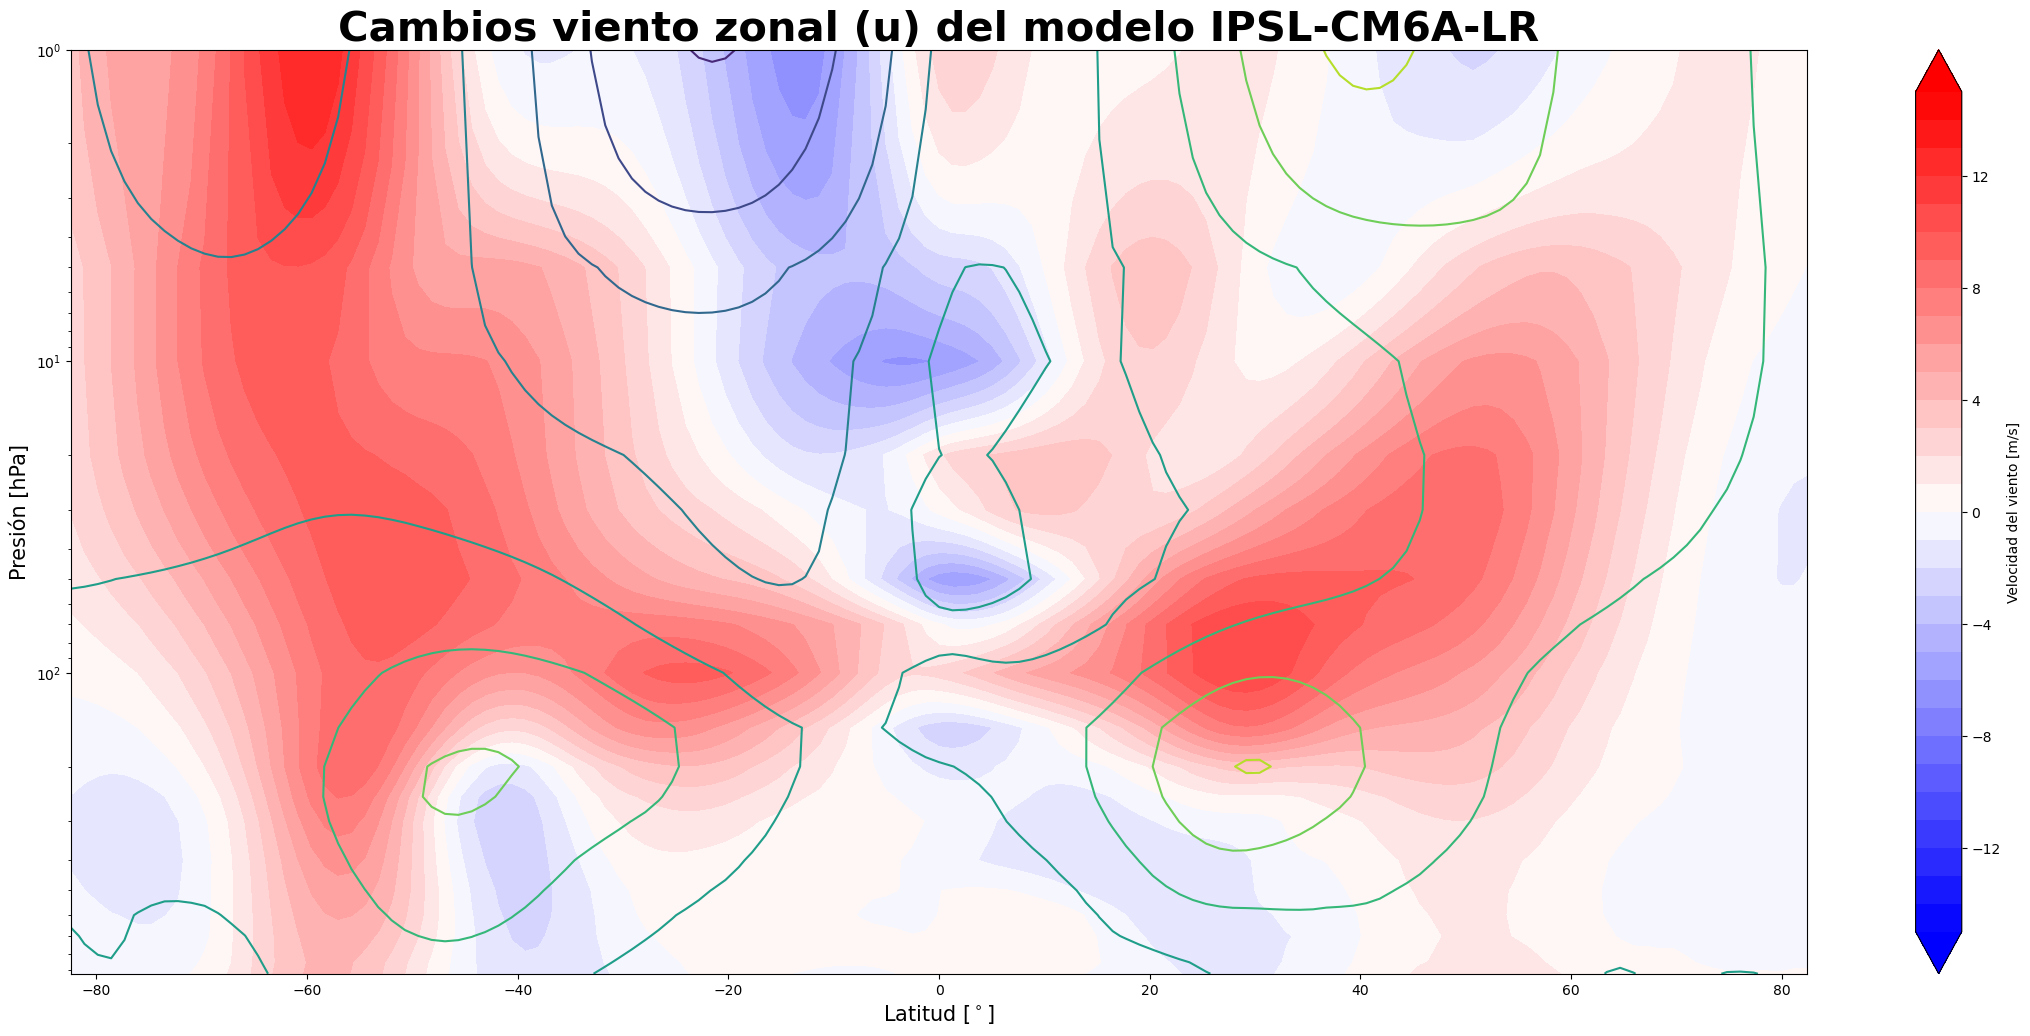

In [25]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1)
levels = np.arange(-15,16,1)
im = ax.contourf(latT,lev/100,dif_u,levels,cmap='bwr',extend='both')
ax.set_yscale('log')
ax.invert_yaxis()
fig.colorbar(im,ax=ax, label='Velocidad del viento [m/s]') #Para la barra de colores
ii = ax.contour(latT,lev/100,mean_u_past)
ax.set_xlabel('Latitud [$^\circ$]',fontsize=15)
ax.set_ylabel('Presión [hPa]',fontsize=15)
ax.set_title('Cambios viento zonal (u) del modelo IPSL-CM6A-LR',fontsize=30,weight='bold')
fig.savefig('Cambios viento zonal (u) del modelo IPSL-CM6A-LR.png')

#### Repetimos los pasos para  el modelo CESM2-WACCM

In [26]:
var1_u= r'CESM2-WACCM/ua_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412_zm3.nc'
var2_u= r'CESM2-WACCM/ua_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012_zm3.nc'
file1= xr.open_dataset(path+var1_u)
file2= xr.open_dataset(path+var2_u)

Realizamos la selección de los meses invernales y luego calculamos los promedios de la variable para cada periodo de estudio

In [27]:
#seleccionamos los meses invernales ayudándonos de la función gropuby de xarray
file1_inv= file1.groupby('time.season')['DJF']
file2_inv= file2.groupby('time.season')['DJF']

lev = file1_inv.plev
latT = file1_inv.lat
ua = file1_inv.ua
ua_fut = file2_inv.ua

nt, nlev, ny, nx = ua.shape
nm = 3
nyr = int(nt/nm)
ua = np.reshape(ua,[nyr,nm,nlev,ny])
ua_mean = np.mean(ua,axis = 1)
ua_mean_past = ua_mean[121:151,:,:]
mean_u_past = np.mean(ua_mean_past,axis =0)
mean_u_past = np.reshape(mean_u_past,(nlev,ny))

###futuro
ntf, nlev, ny, nx = ua_fut.shape
nm = 3
nyrf = int(ntf/nm)
ua_fut = np.reshape(ua_fut,[nyrf,nm,nlev,ny])
ua_mean_fut = np.mean(ua_fut,axis = 1)
ua_mean_fut = ua_mean_fut[-30:,:,:]
mean_u_future = np.mean(ua_mean_fut,axis =0)
print(mean_u_future.shape)
dif_u = np.array(mean_u_future)-np.array(mean_u_past)

(18, 176)


Representación de las diferencias

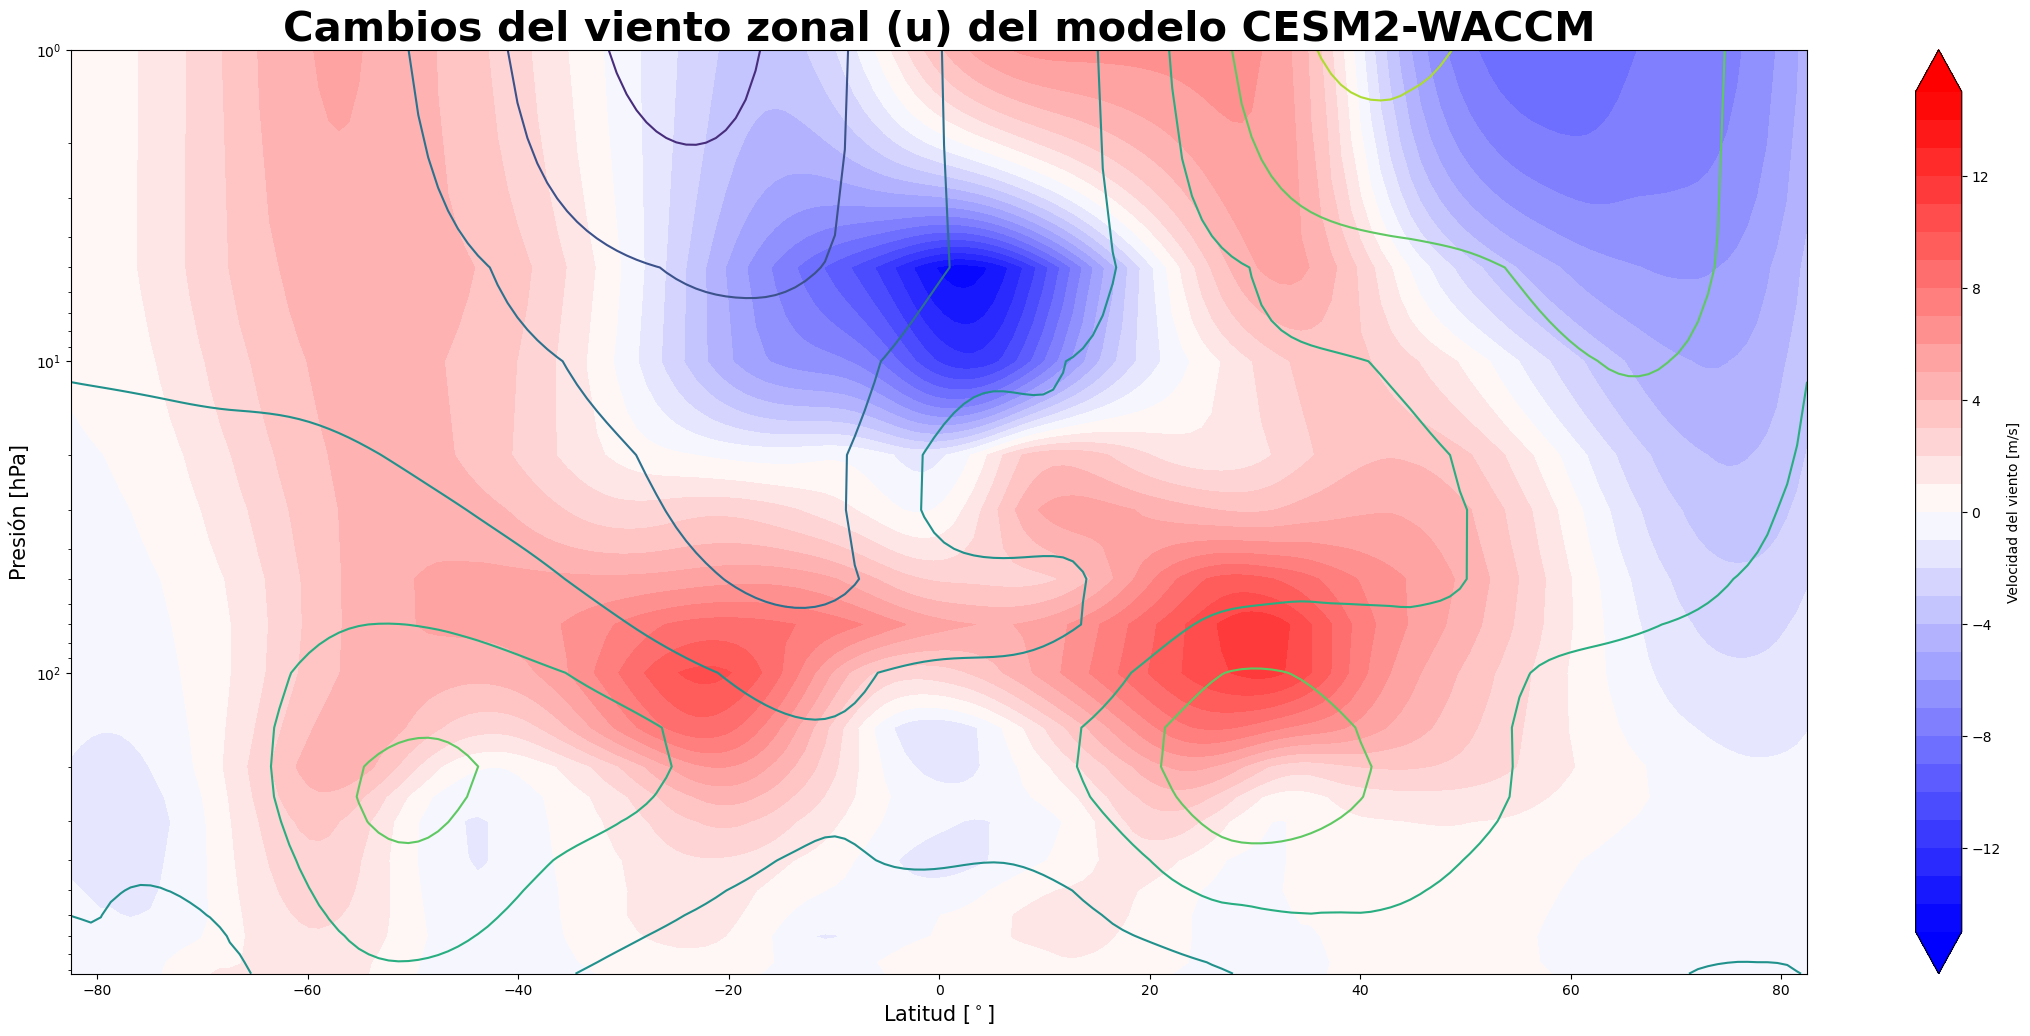

In [28]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1)
levels = np.arange(-15,16,1)
im = ax.contourf(latT,lev/100,dif_u,levels,cmap='bwr',extend='both')
ax.set_yscale('log')
ax.invert_yaxis()
fig.colorbar(im,ax=ax, label='Velocidad del viento [m/s]') #Para la barra de colores
ii = ax.contour(latT,lev/100,mean_u_past)
ax.set_xlabel('Latitud [$^\circ$]',fontsize=15)
ax.set_ylabel('Presión [hPa]',fontsize=15)
ax.set_title('Cambios del viento zonal (u) del modelo CESM2-WACCM',fontsize=30,weight='bold')
fig.savefig('Cambios del viento zonal (u) del modelo CESM2-WACCM.png')

# Ejercicio 3: Validación del modelo

## 3.1. Validación del modelo IPSL-CM6A-LR.

Compara el comportamiento del modelo en el periodo de referencia con las observaciones. Para ello puedes servirte de la herramienta online de la NOAA para visualizar campos atmosféricos del reanálisis de NCEP (https://psl.noaa.gov/cgi-bin/data/composites/printpage.pl). 

#### Temperatura cerca de superficie modelo

Realizamos la representación para el periodo de referencia 

In [29]:
var1_tas= r'IPSL-CM6A-LR/tas_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc'
file1= xr.open_dataset(path+var1_tas)

lon= file1.lon
lat= file1.lat
TAS= file1.tas

nt,nlat,nlon= TAS.shape
nm=12 #numero de meses
nyears= int(nt/nm)

TAS= np.reshape(np.array(TAS), (int(nyears),nm,nlat,nlon))
ann_TAS= np.mean(TAS,axis=1)
ann_TAS_past= ann_TAS[121:151,:,:]
ann_TAS_mean_past= np.mean(ann_TAS_past, axis=0) #promedio tas en el periodo presente

C:\Anaconda\envs\analisisdatosucm\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Anaconda\envs\analisisdatosucm\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


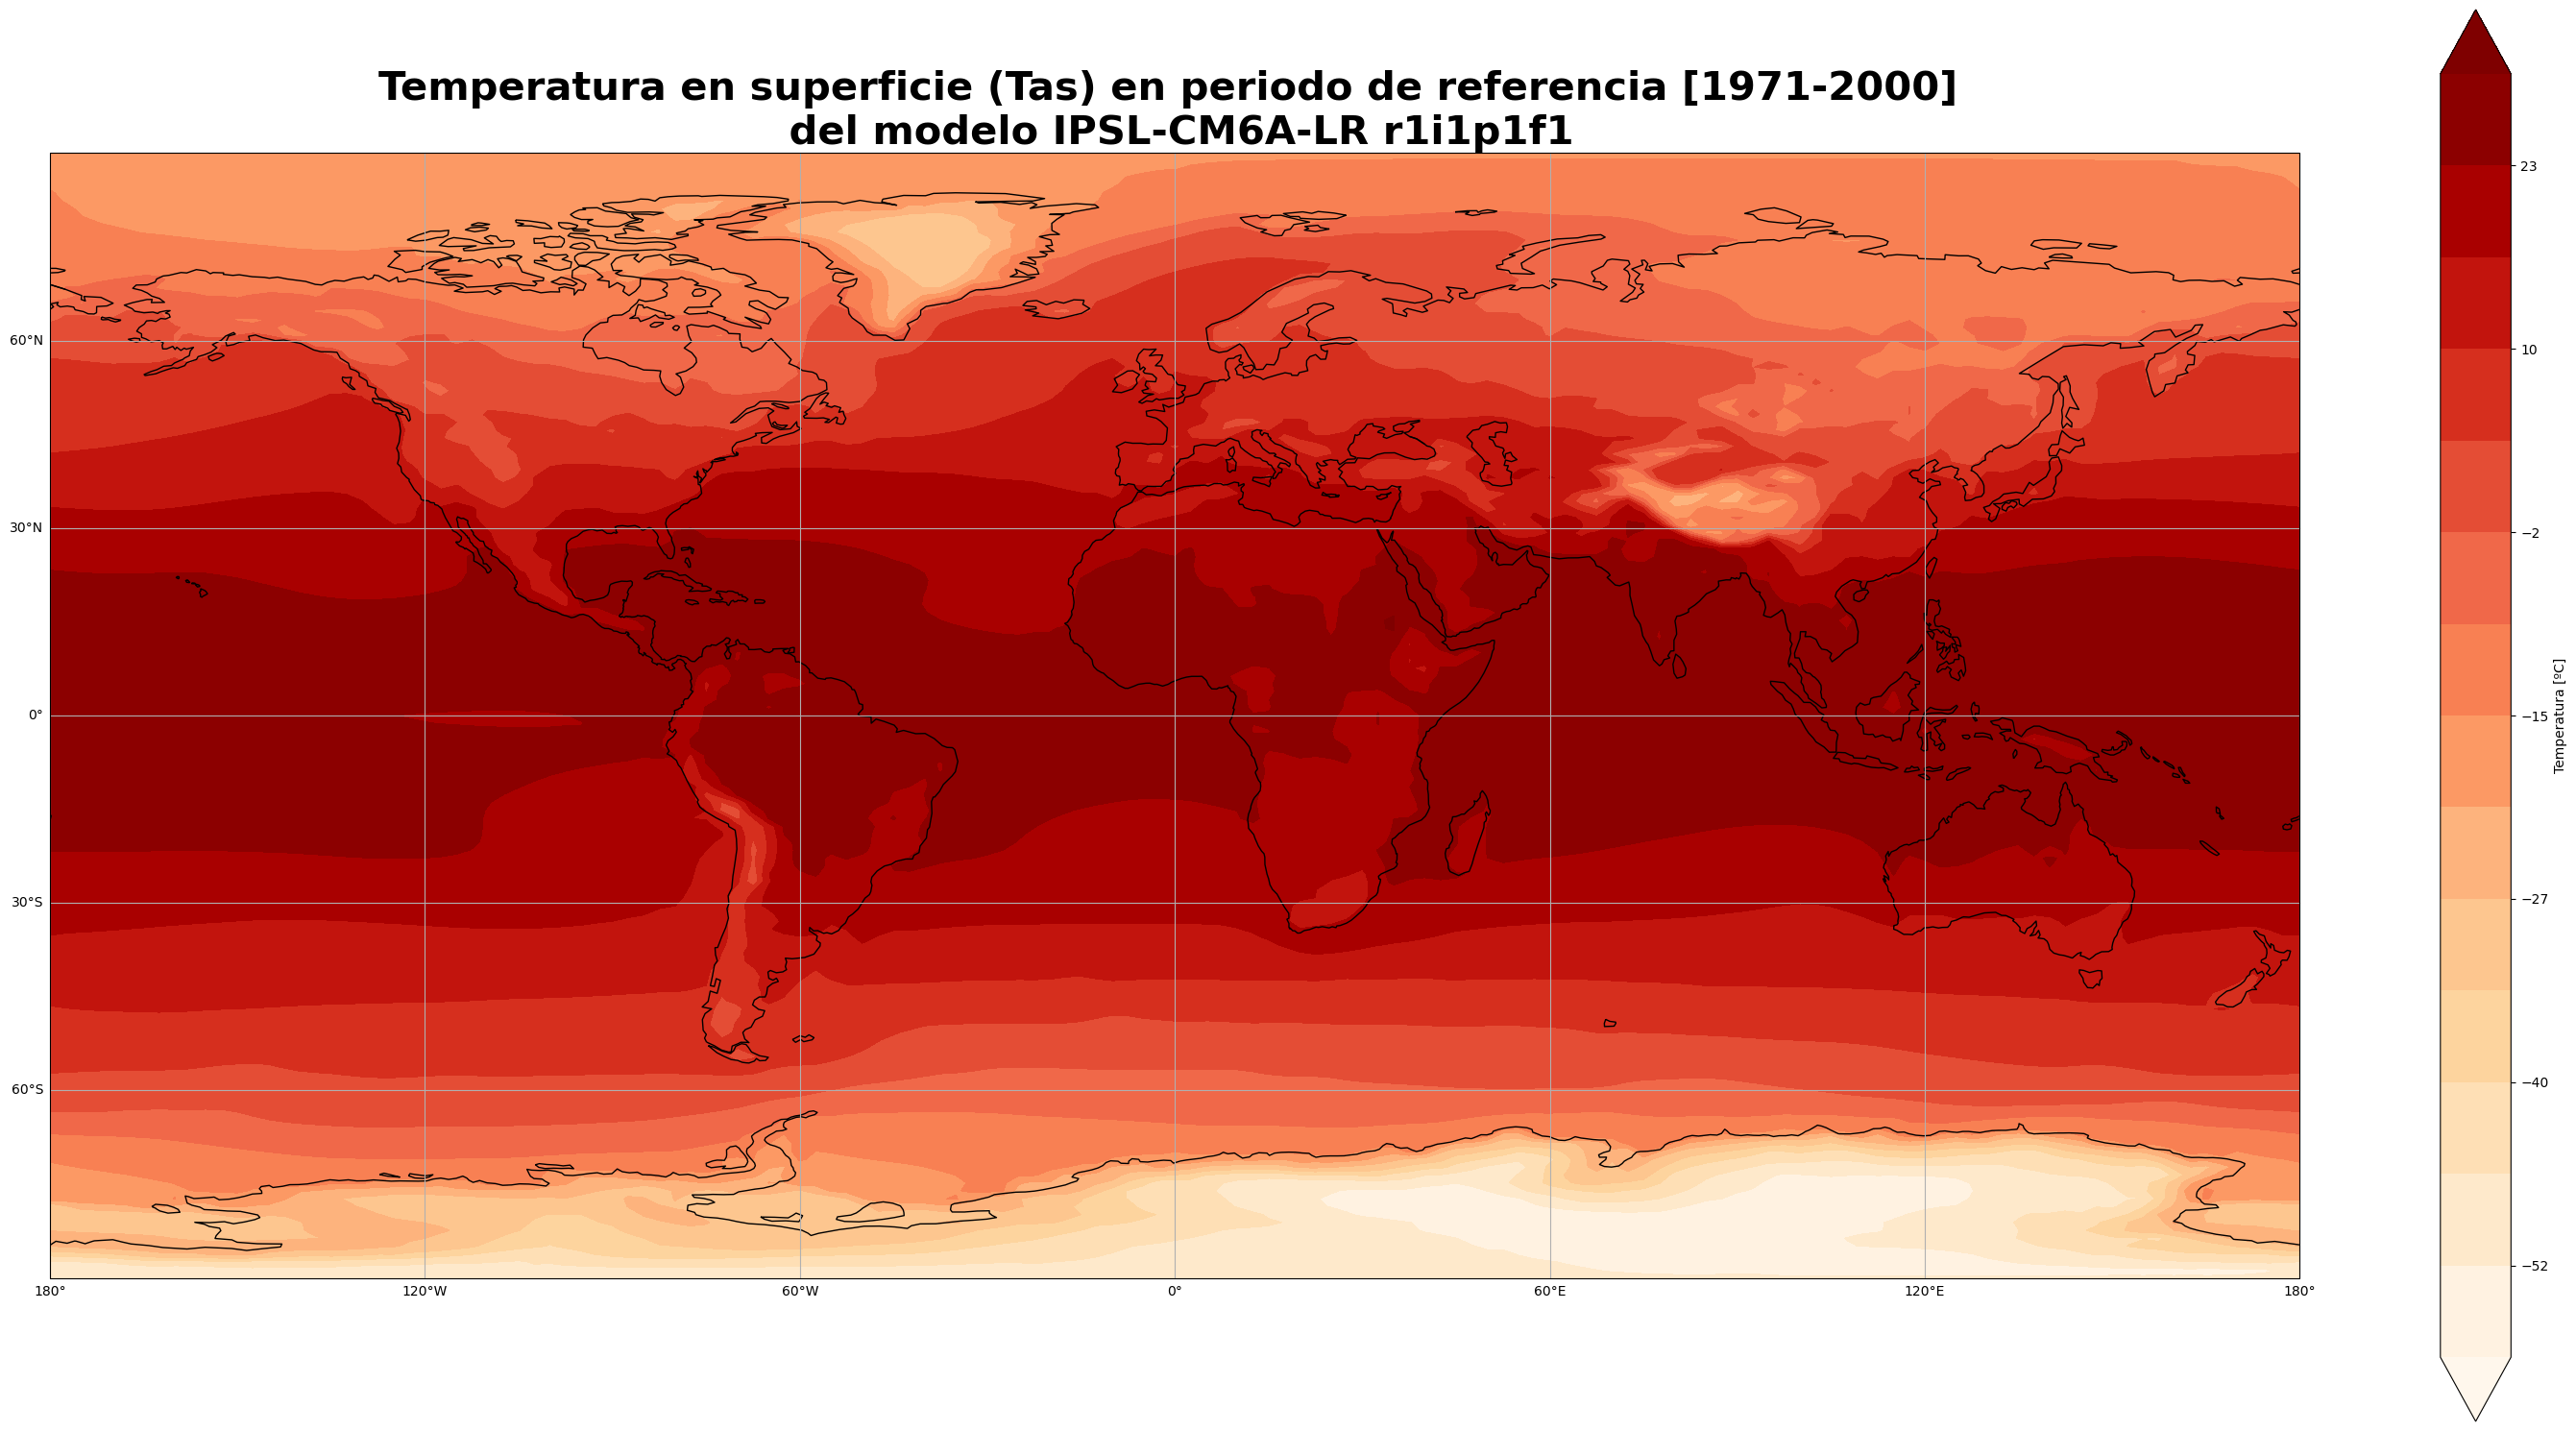

In [30]:
fig= plt.figure(figsize=(30,15))
ax= fig.add_subplot(1,1,1, projection= ccrs.PlateCarree(0))
ml1= ann_TAS_mean_past-273.15 #para pasarlo a grados celcius
levels= np.round(np.linspace(np.min(ml1),np.max(ml1),num=15),decimals=0) #para el colorbar
cml, clon= add_cyclic_point(ml1, coord=lon) #porque si no se crea una banda en blanco
im= ax.contourf(clon,lat,cml,levels=levels,cmap='OrRd', extend='both')
ax.coastlines()
fig.colorbar(im,ax=ax, label='Temperatura [ºC]')
gl=ax.gridlines(draw_labels = True)
gl.ylabels_right = False
gl.xlabels_top = False
ax.set_title('Temperatura en superficie (Tas) en periodo de referencia [1971-2000] \n del modelo IPSL-CM6A-LR r1i1p1f1', fontsize=30, weight='bold')
plt.tight_layout()
fig.savefig('Temperatura en superficie (Tas) en periodo de referencia [1971-2000] del modelo IPSL-CM6A-LR r1i1p1f1.png')

#### Temperatura cerca de superficie reanálisis

Esta parte es opcional. Para la comparación podéis utilizar los mapas obtenidos directamente de la página de la NOAA indicada anteriormente.

#### Media zonal T en troposfera y estratosfera en modelo

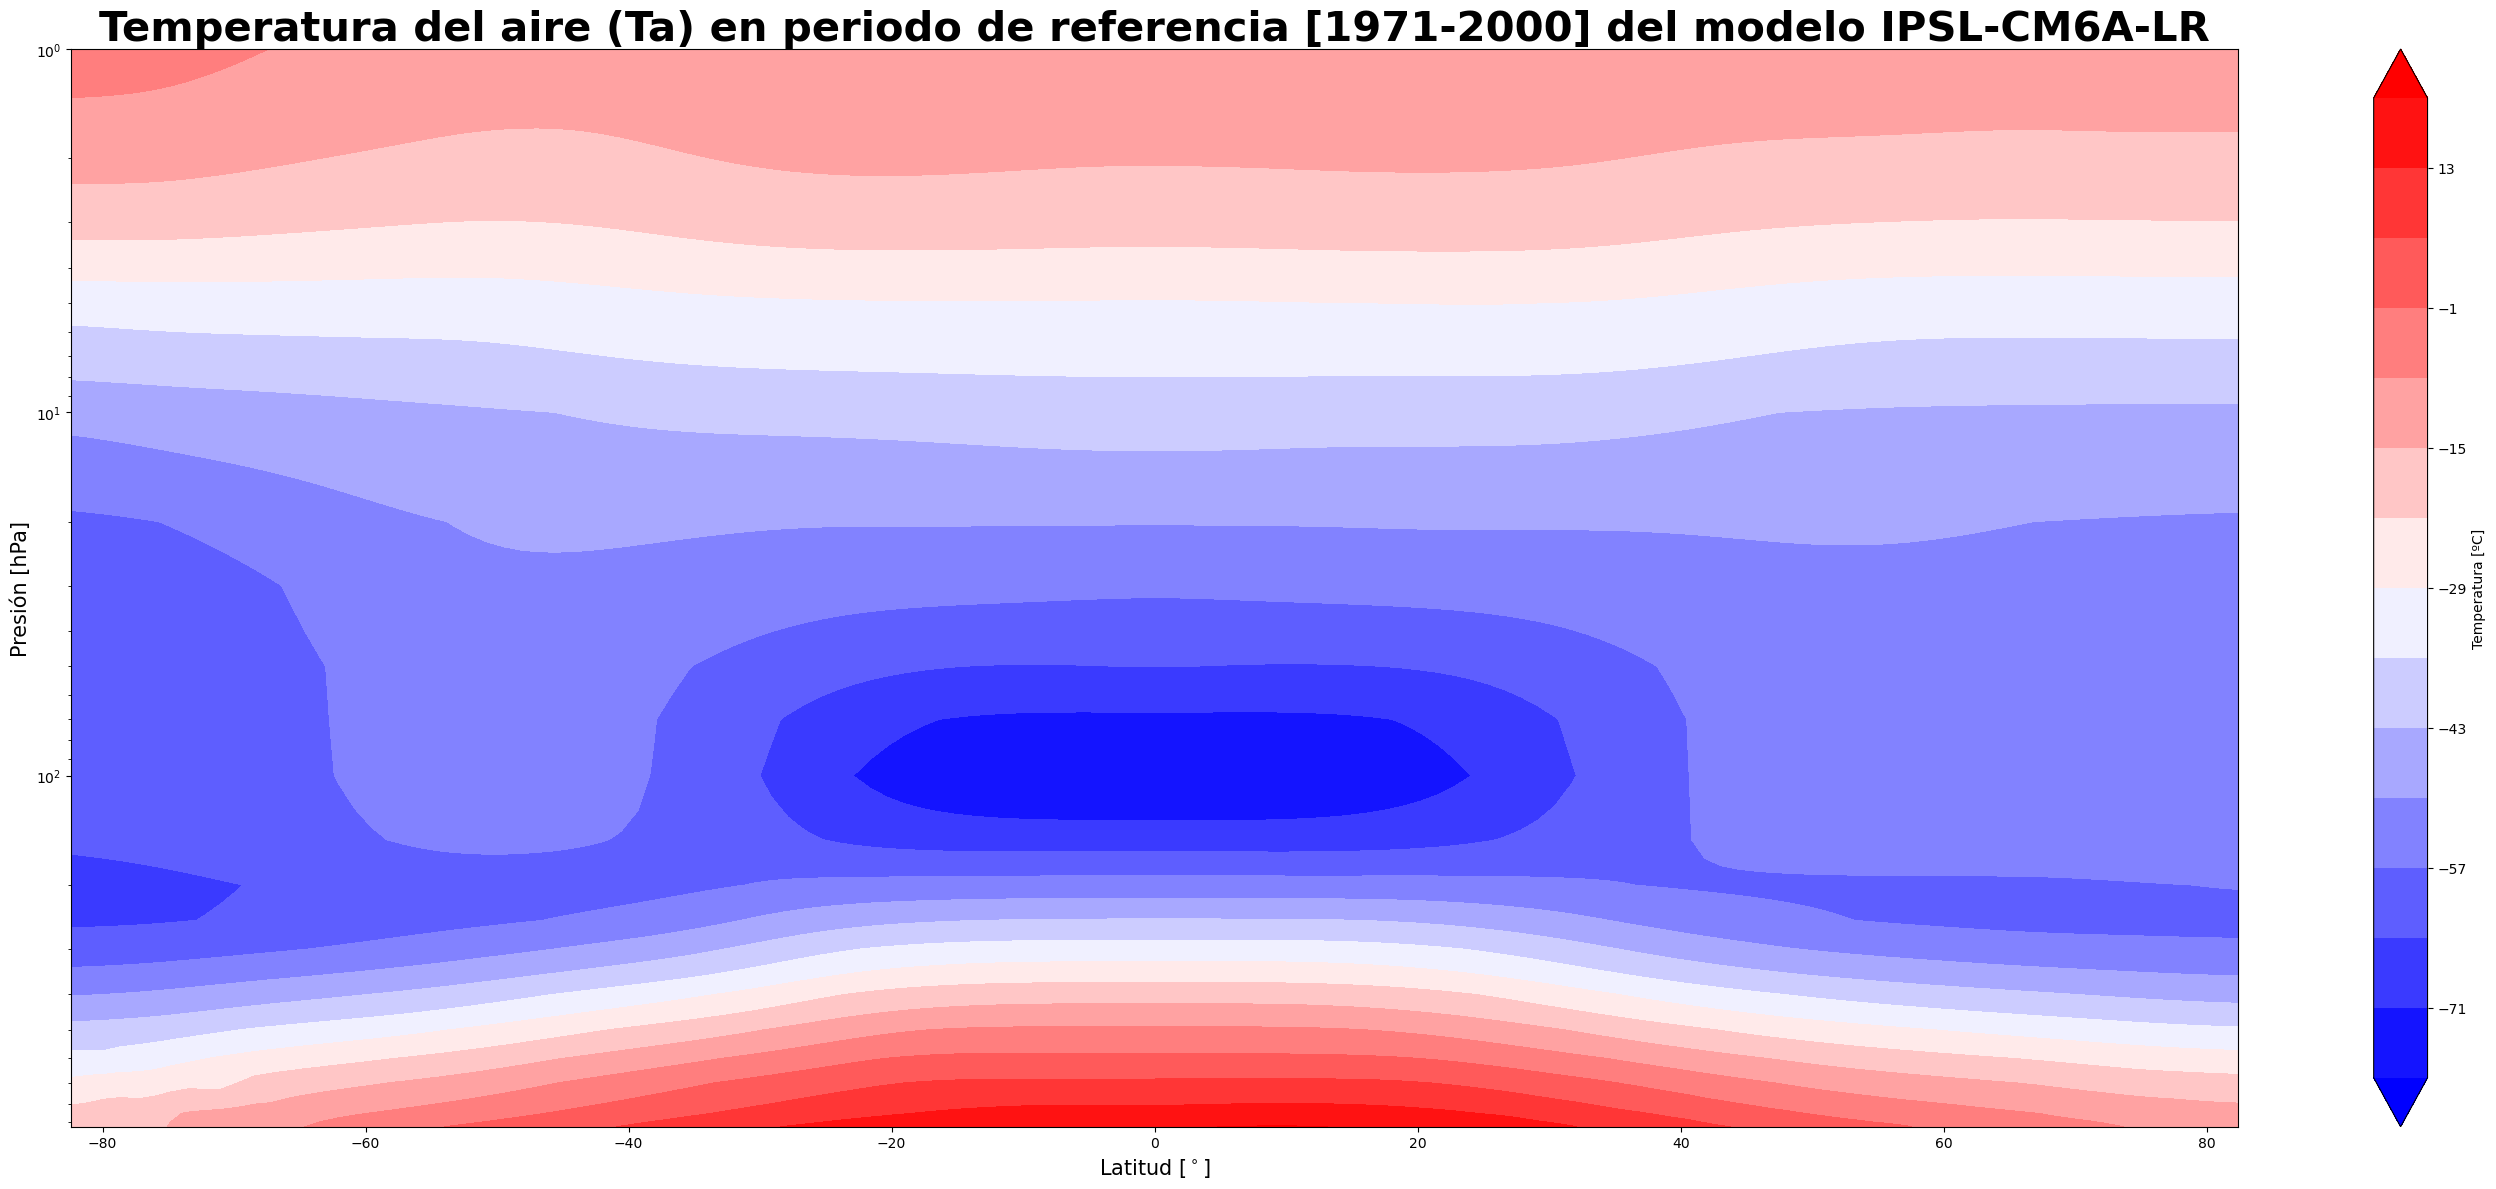

In [31]:
var1= r'IPSL-CM6A-LR/ta_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412_zm3.nc'
fil = nc.Dataset(path+ var1)
lev = fil.variables['plev'][:]
latT = fil.variables['lat'][:]
TA = fil.variables['ta'][:]

nt, nlev, ny, nx = TA.shape
nm = 12
nyr = int(nt/nm)
TA = np.reshape(TA,[nyr,nm,nlev,ny])-273.15 #para pasar a celcius
TAm = np.mean(TA,axis = 1)
TAmpast = TAm[121:151,:,:]
mediaTpast = np.mean(TAmpast,axis =0)
mediaTpast = np.reshape(mediaTpast,(nlev,ny))

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1)
levels = np.round(np.linspace(np.min(mediaTpast),np.max(mediaTpast),num=15),decimals=0)
im = ax.contourf(latT,lev/100,mediaTpast,levels,cmap='bwr',extend='both')
ax.set_yscale('log')
ax.invert_yaxis()
fig.colorbar(im,ax=ax,label='Temperatura [ºC]') #Para la barra de colores
ax.set_xlabel('Latitud [$^\circ$]',fontsize=15)
ax.set_ylabel('Presión [hPa]',fontsize=15)
#ii = ax.contour(latT,lev/100,mediaTpast)
ax.set_title('Temperatura del aire (Ta) en periodo de referencia [1971-2000] del modelo IPSL-CM6A-LR',fontsize=30,weight='bold')
plt.tight_layout()
fig.savefig('Temperatura del aire (Ta) en periodo de referencia [1971-2000] del modelo IPSL-CM6A-LR.png')

#### Media zonal T en troposfera y estratosfera en reanálisis

Esta parte es opcional. Para la comparación podéis utilizar los mapas obtenidos directamente de la página de la NOAA indicada anteriormente.

#### Media zonal u en troposfera y estratosfera en modelo

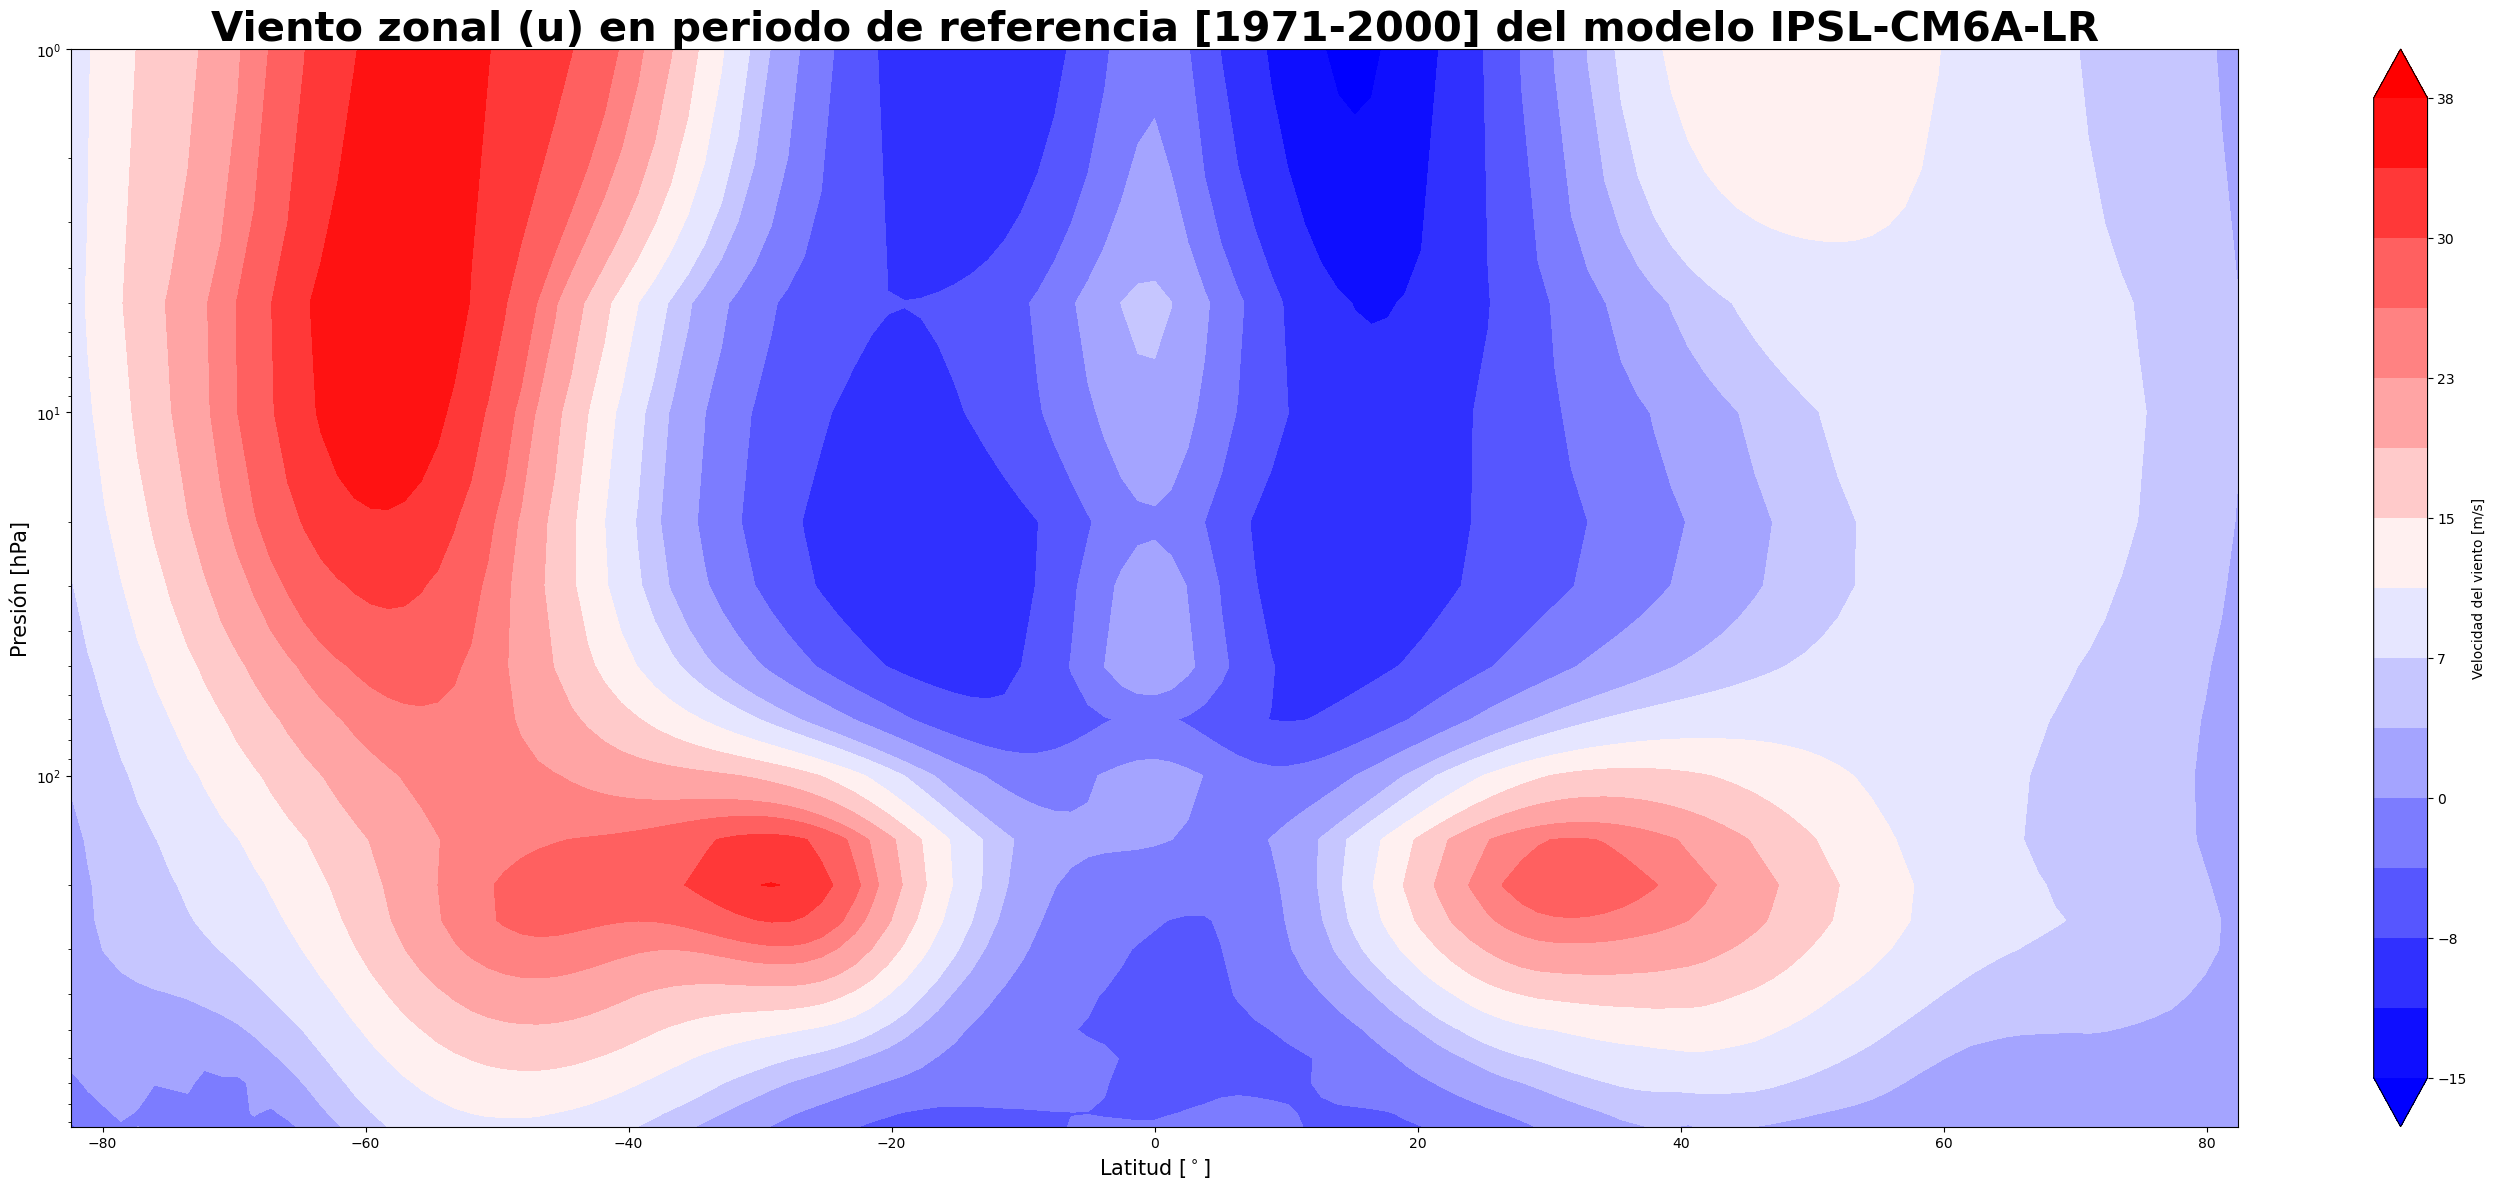

In [32]:
var1_u= r'IPSL-CM6A-LR/ua_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412_zm3.nc'
file1= xr.open_dataset(path+var1_u)

lev = file1.plev
latT = file1.lat
ua = file1.ua

nt, nlev, ny, nx = ua.shape
nm = 3
nyr = int(nt/nm)
ua = np.reshape(ua,[nyr,nm,nlev,ny])
ua_mean = np.mean(ua,axis = 1)
ua_mean_past = ua_mean[121:151,:,:]
mean_u_past = np.mean(ua_mean_past,axis =0)
mean_u_past = np.reshape(mean_u_past,(nlev,ny))

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1)
levels = np.round(np.linspace(np.min(mean_u_past),np.max(mean_u_past),num=15),decimals=0)
im = ax.contourf(latT,lev/100,mean_u_past,levels,cmap='bwr',extend='both')
ax.set_yscale('log')
ax.invert_yaxis()
fig.colorbar(im,ax=ax,label='Velocidad del viento [m/s]') #Para la barra de colores
ax.set_xlabel('Latitud [$^\circ$]',fontsize=15)
ax.set_ylabel('Presión [hPa]',fontsize=15)
#ii = ax.contour(latT,lev/100,mean_u_past)
ax.set_title('Viento zonal (u) en periodo de referencia [1971-2000] del modelo IPSL-CM6A-LR',fontsize=30,weight='bold')
plt.tight_layout()
fig.savefig('Viento zonal (u) en periodo de referencia [1971-2000] del modelo IPSL-CM6A-LR.png')

#### Media zonal u en troposfera y estratosfera en reanálisis


Esta parte es opcional. Para la comparación podéis utilizar los mapas obtenidos directamente de la página de la NOAA indicada anteriormente.